In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd


# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

from scipy import stats
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Preprocesado y modelado
plt.rcParams["figure.figsize"] = (10,8)

In [2]:
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Input
Cargamos los datos:

In [3]:
df = pd.read_csv("data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Análisis exploratorio

1. ver que tengo en el df y los tipos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


- variables continuas:
  - `charges`
  - `bmi`
  - `age`
- variables discretas:
  - `sex`
  - `children`
  - `region`


la variable respuesta -- la que se va a intentar predecir. en este caso, será `charges`. el resto de variables serán varables predictoras:
- `age`
- `sex`
- `bmi`
- `children`
- `smoker`
- `region`

2. ver el número de nulos que tengo en el dataset y ver que puedo hacer con ello

una columna es quitable en cuanto a úmero de nulos será el 60%-70% de valores nulos

In [5]:
# Número de datos nulos por columna
# ==============================================================================
df.isnull().sum() / df.shape[0]

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

3. check duplicados -- si hay filas duplicadas, te las zumbas

In [6]:
df.duplicated().sum() / df.shape[0]

0.0007473841554559044

4. check los tipos de datos

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


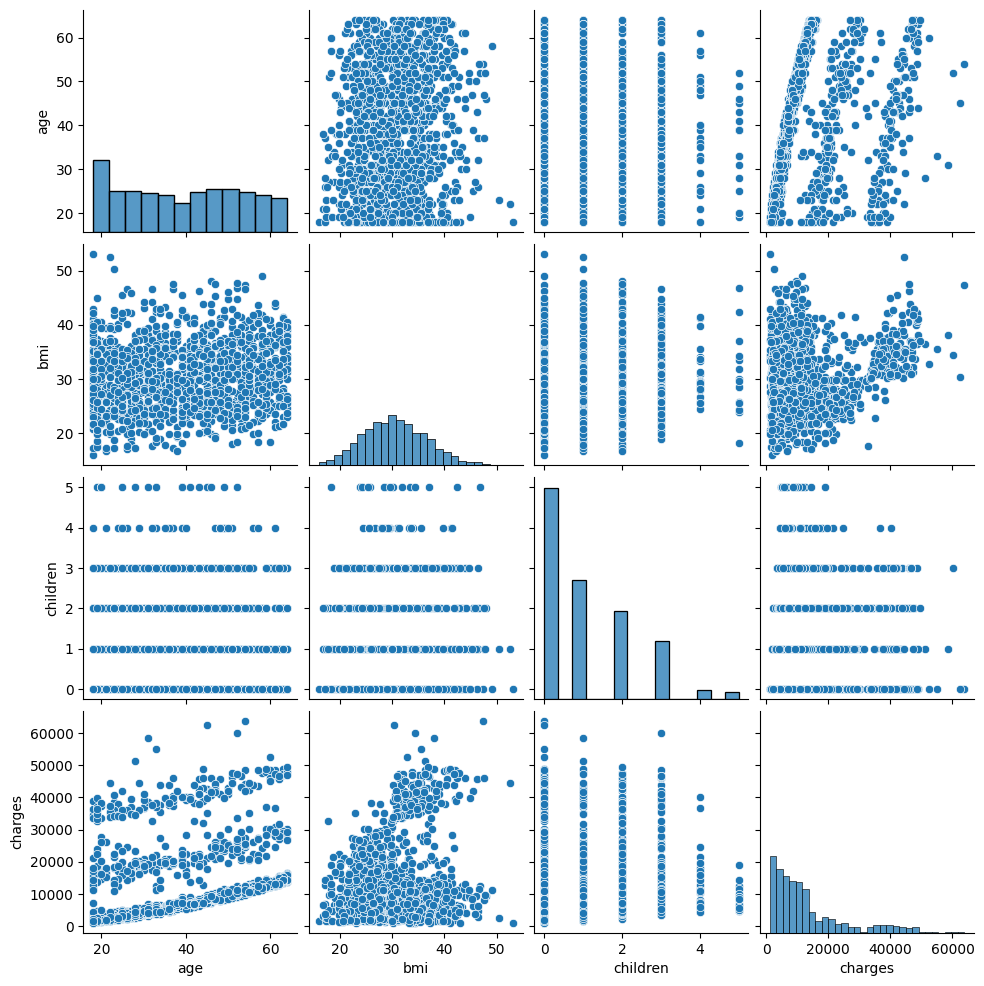

In [8]:
sns.pairplot(data=df);

## Variable respuesta

la variable respuesta en este caso será `charges`.

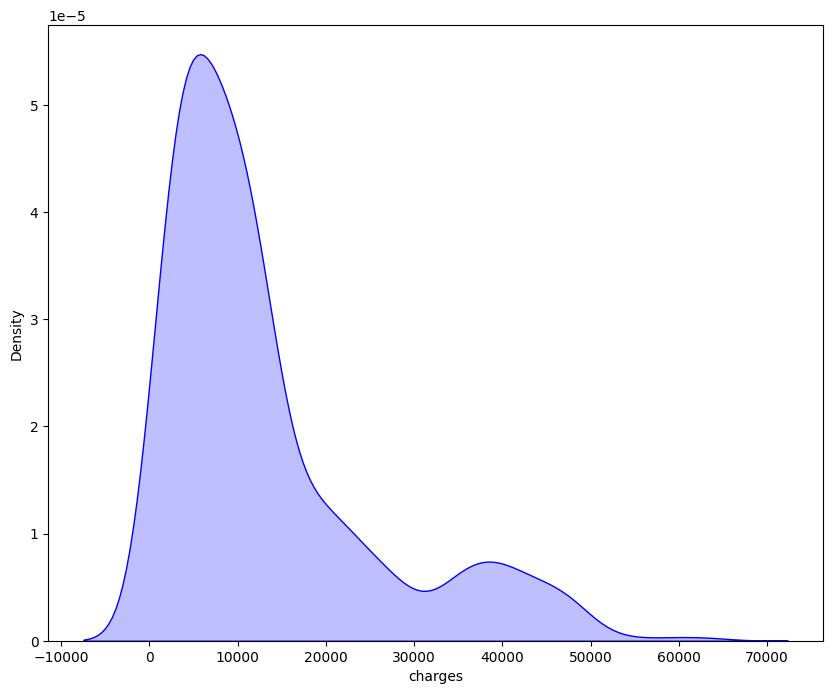

In [9]:
# vamos a ver visualmente como está distribuida la variable respuesta

##esto es un resumen un histograma

sns.kdeplot(
    df.charges, 
    color = "blue", 
    fill = True);

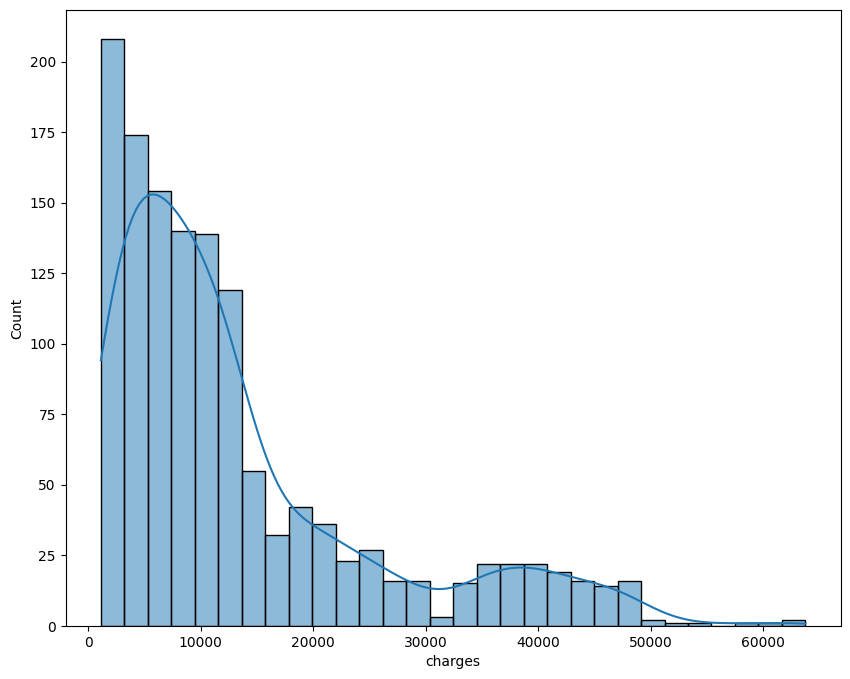

In [10]:
# cuantas casas tienen de media el valor que indica el eje x
sns.histplot(data = df, x = 'charges', kde = True);

La variable respuesta no es normal -- aunque tiene una forma normal, con cierto sesgo hacia la izquierda.

In [11]:
stats.shapiro(df["charges"])

ShapiroResult(statistic=0.8146880269050598, pvalue=1.150477698013898e-36)

otra de las soluciones posibles, sin transformar la gráfica sería dividir el conjunto de datos y quitarnos la parte de la derecha, ya que es la parte que no es simétrica de la distriución.

In [12]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


## Variables predictoras

### Variables numéricas


In [13]:
# exploramos cuáles son los principales estadísticos de las variables numéricas

df_numericas = df.select_dtypes(include = np.number)#.describe()
df_numericas

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


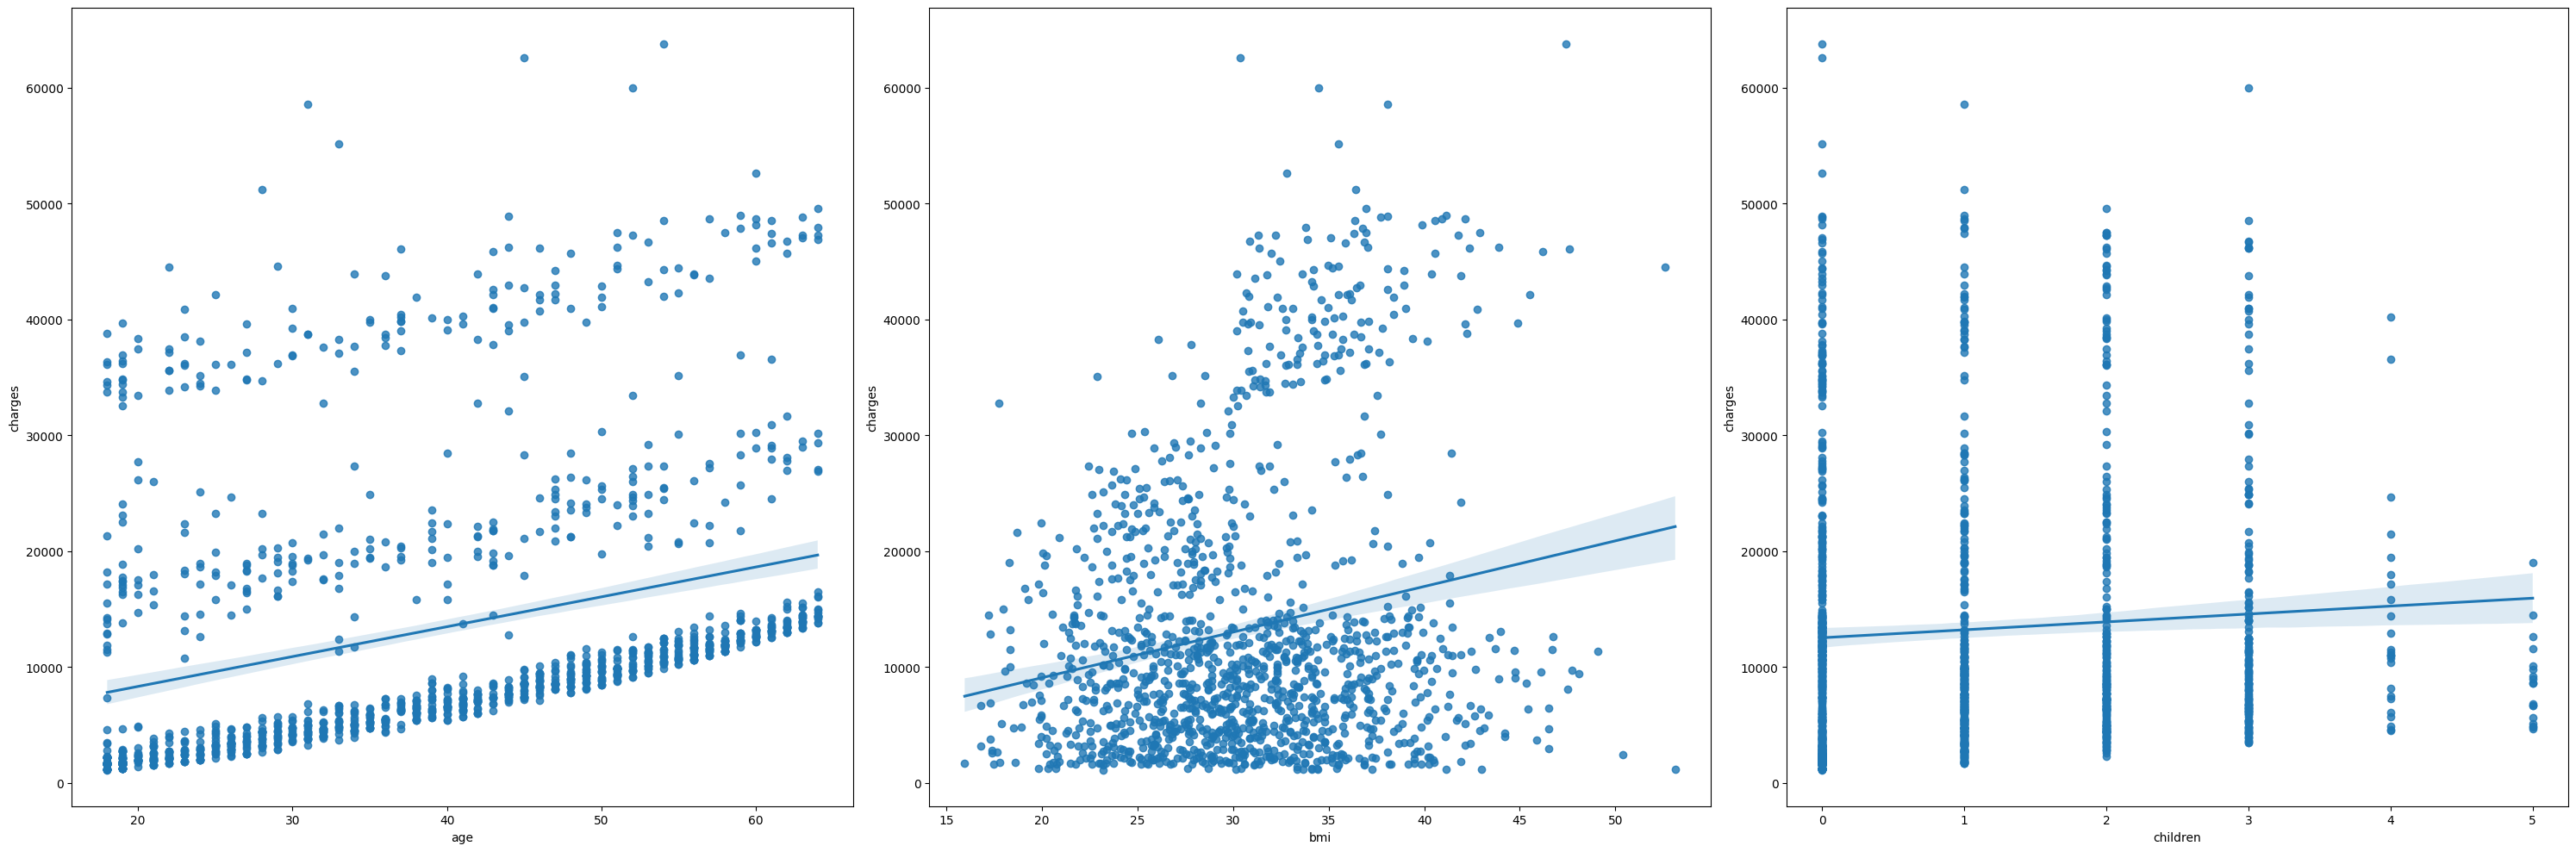

In [14]:
fig, axes = plt.subplots(ncols=3, figsize = (30,10))
axes = axes.flat
columnas = df_numericas.drop(['charges'], axis = 1)  
for i, columns in enumerate(columnas.columns):
    sns.regplot(data = df, x = columns, y = 'charges', ax = axes[i])
fig.tight_layout()

vale, confirmamos que la variable `children` es numérica, pero se puede considerar una variable categórica con 6 categorías.

la variable `bmi` se dispersa.

la variable `age` tiene una distribución más extraña -- parece que tiene tres partes que son lineales.

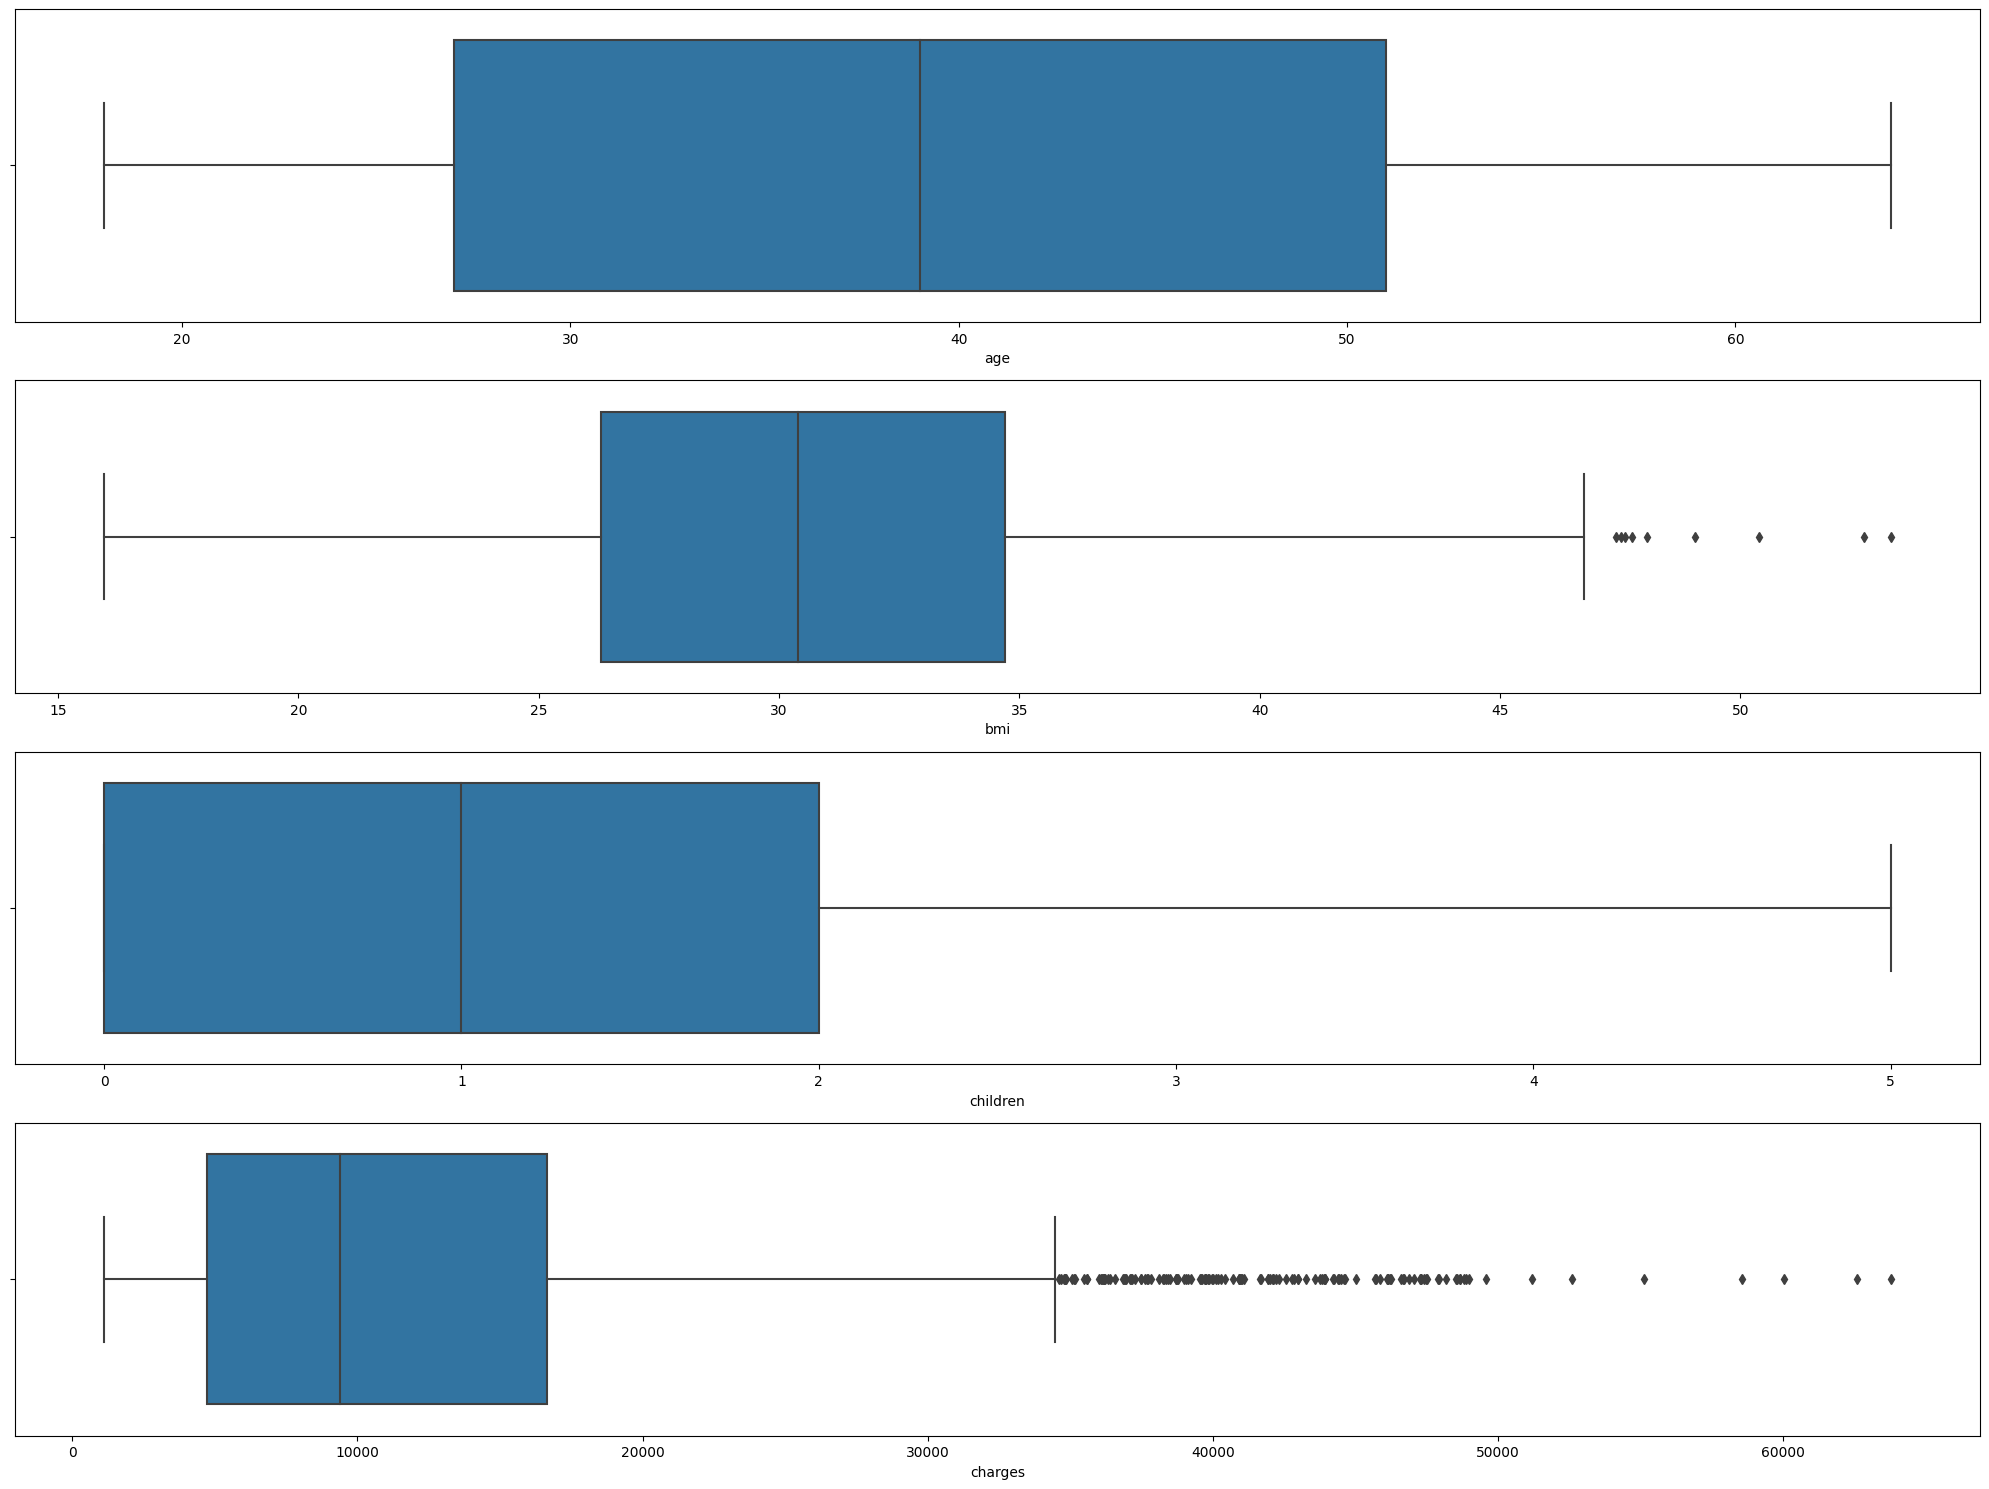

In [15]:
fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

Mirando la mezcla de variables respuesta + variables predictoras, vemos que donde hay outliers es en el campo `bmi` de las variables predictoras y en la varable respuesta `charges`.

### Correlación entre variables numéricas

ojo: solo entre variables numéricas

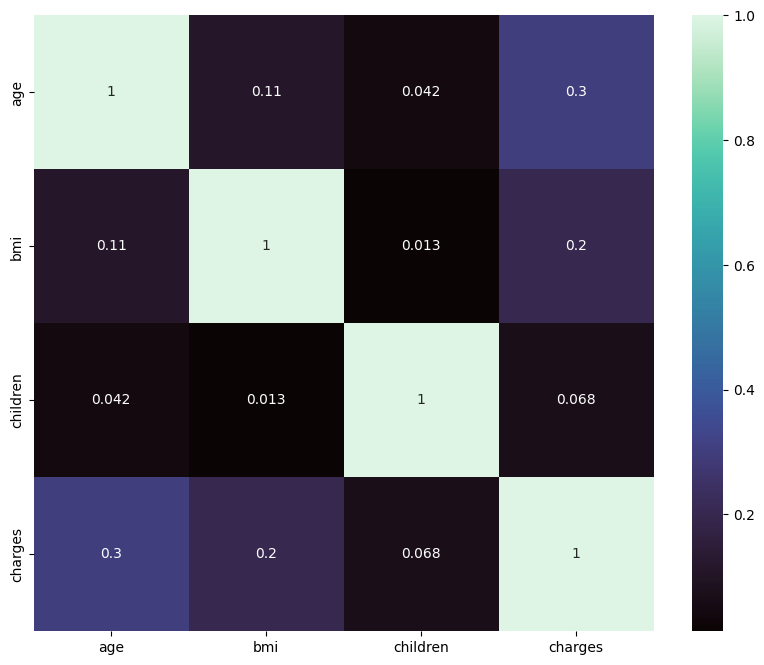

In [16]:
sns.heatmap(df.corr(), 
           cmap = "mako", 
           annot = True);

In [17]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación
## creamos una matriz triangular

mask = np.triu(np.ones_like(df.corr(), dtype = bool))
mask


array([[ True,  True,  True,  True],
       [False,  True,  True,  True],
       [False, False,  True,  True],
       [False, False, False,  True]])

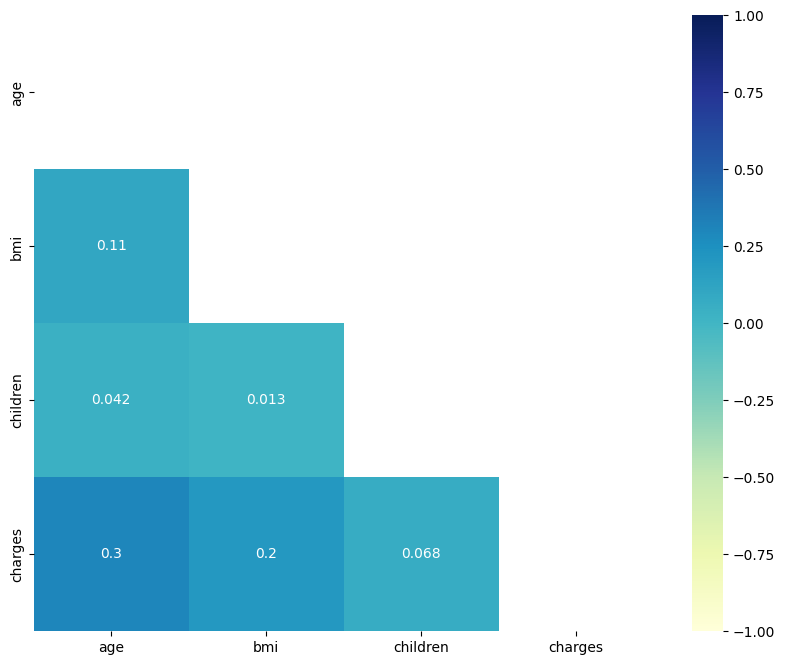

In [18]:
sns.heatmap(df.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True,
           vmin = -1,
           vmax = 1
           );
## ojo, incluir los valores max y min para ver la escala total
## para ver si hay correlación entre dos variables, hay que ver si los valores están en torno al 0.6 - 0.7

Mirando la matriz de correlación, la variable que más influye en la variable respuesta es `age`.

### Variables categóricas

In [19]:
df_categoricas = df.select_dtypes(include='object')
df_categoricas.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


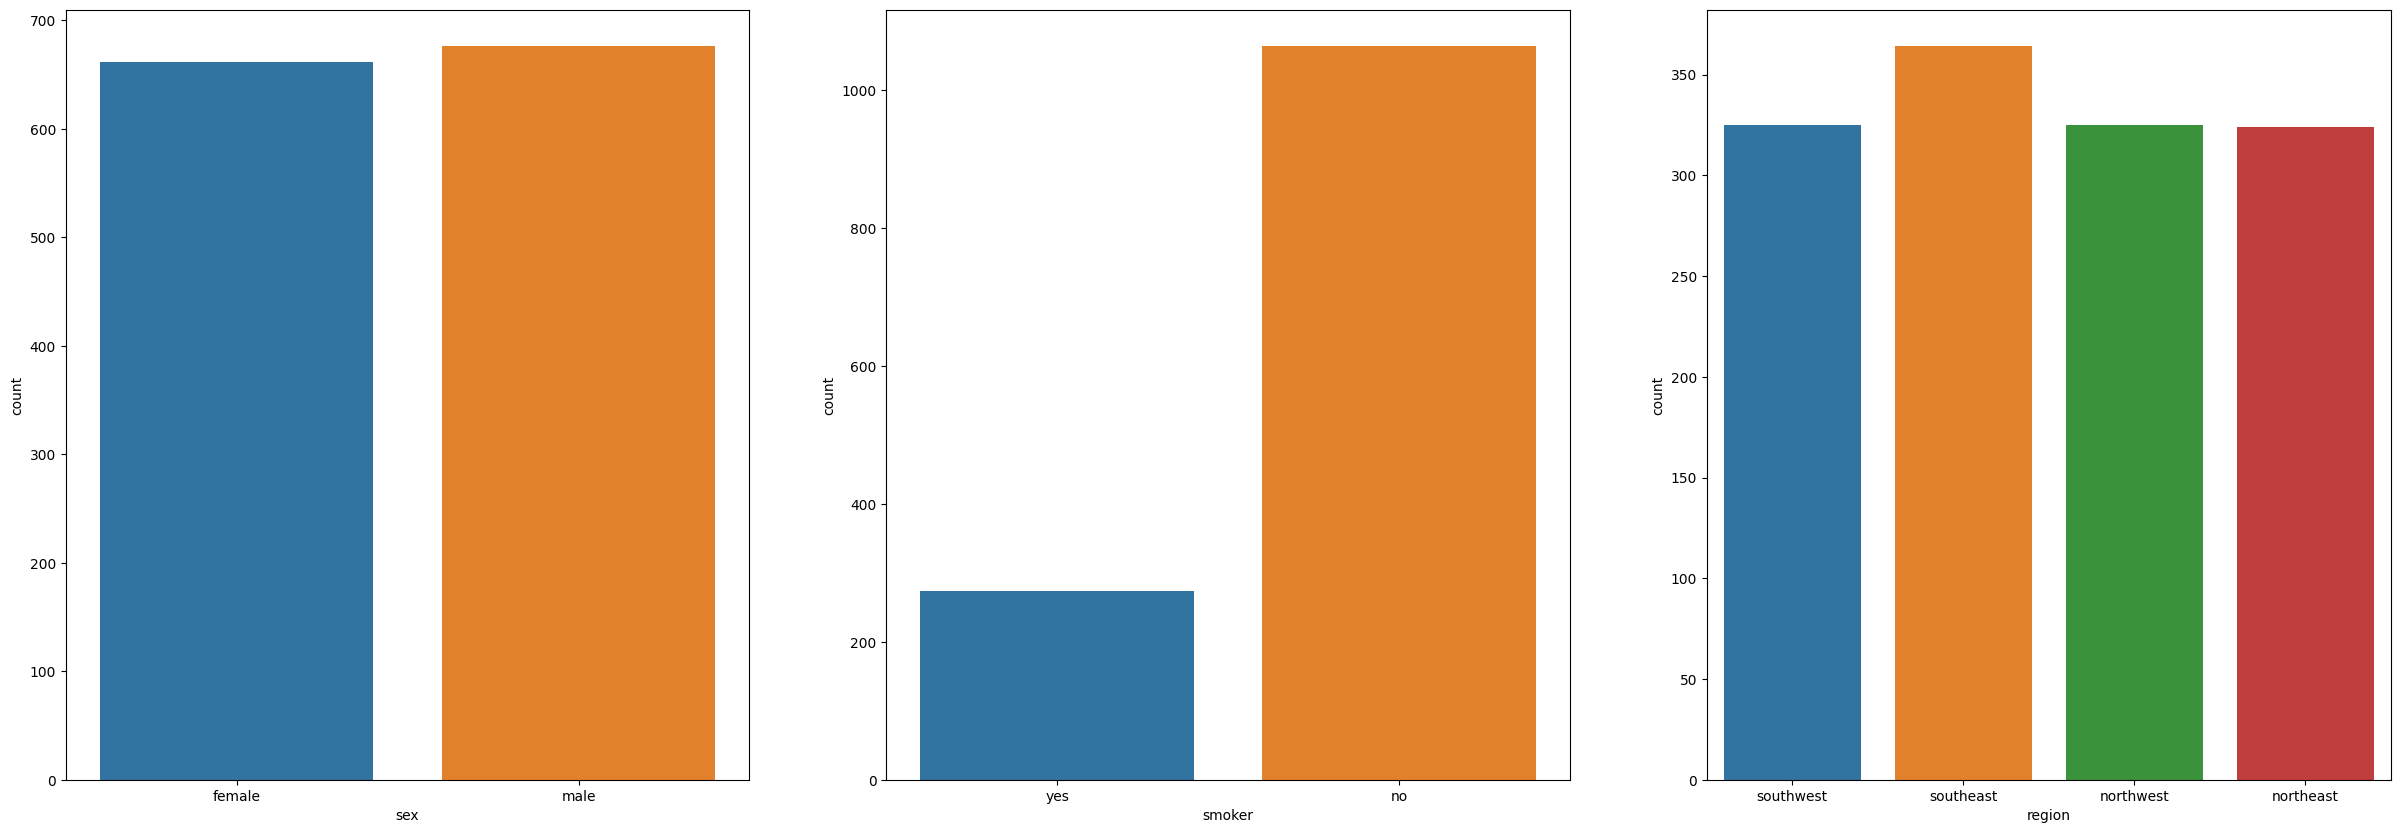

In [20]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

axes = axes.flat

for i, columna in enumerate(df_categoricas.columns):
    sns.countplot(data = df, 
                  x = columna, 
                  ax = axes[i]);

Vemos que tanto `sex` como `region`. Lo que sí que vemos que hay una diferencia significativa es en la cantidad de fumadores. Veamos como se relacionan las variables con los valores de `charges`.

vamos a sacar el precio medio por estados y ver como se distribuyen los precios:

In [21]:
df_cate_sex = df.groupby('sex')['charges'].mean().reset_index()
df_cate_sex.head()

,sex,charges
0,female,12569.578844
1,male,13956.751178


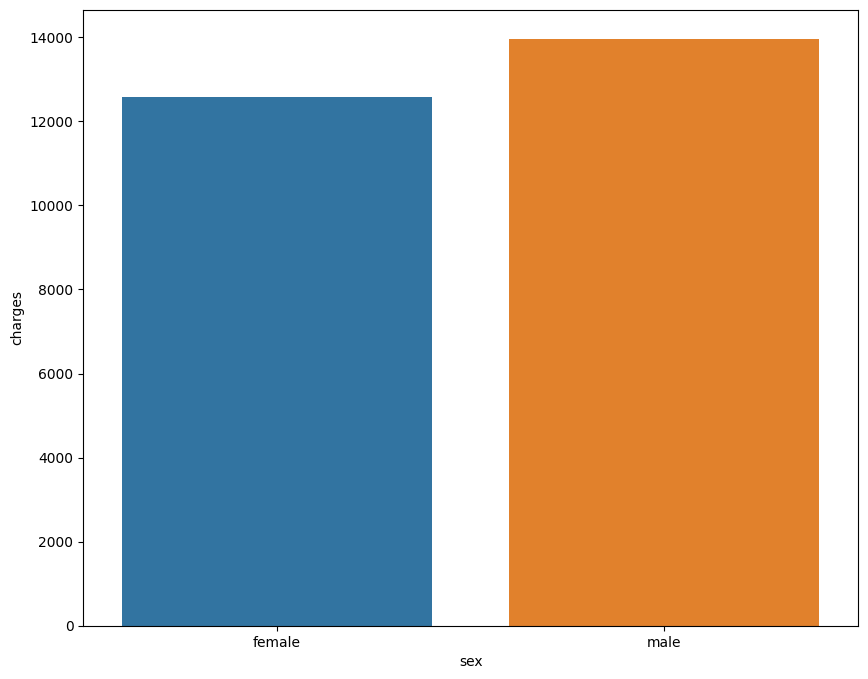

In [22]:
sns.barplot(data=df_cate_sex, x = 'sex', y = 'charges');

In [23]:
df_cate_smoker = df.groupby('smoker')['charges'].mean().reset_index()
df_cate_smoker.head()

,smoker,charges
0,no,8434.268298
1,yes,32050.231832


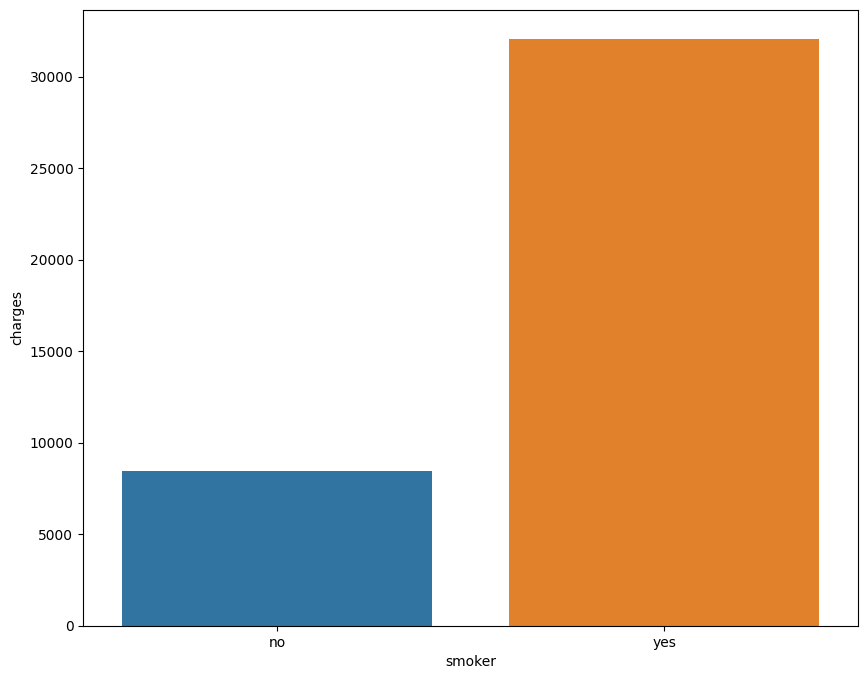

In [24]:
sns.barplot(data=df_cate_smoker, x = 'smoker', y = 'charges');

In [25]:
df_cate_smoker = df.groupby('region')['charges'].mean().reset_index()
df_cate_smoker.head()

,region,charges
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


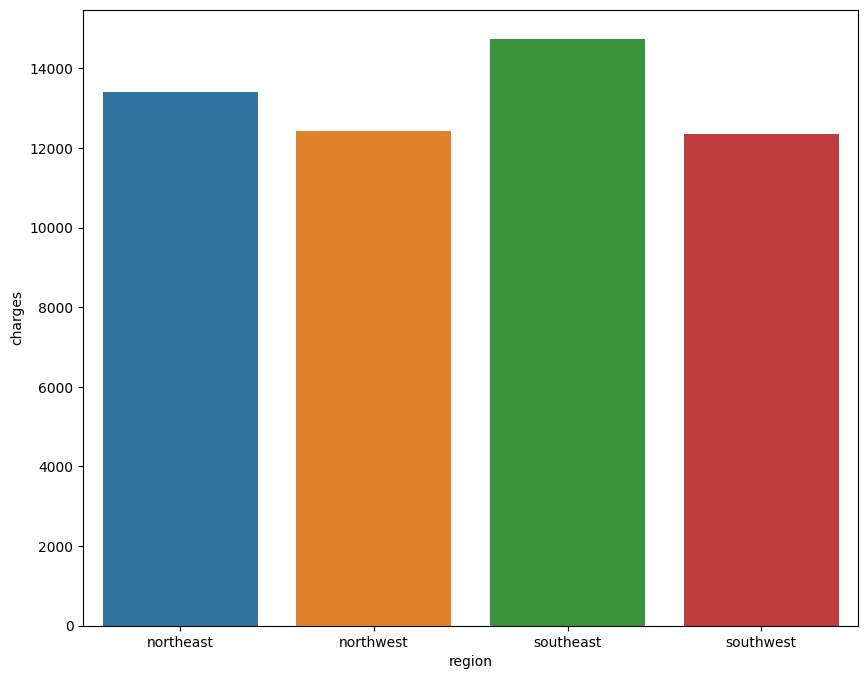

In [26]:
sns.barplot(data=df_cate_smoker, x = 'region', y = 'charges');

Mirando el valor de la prima para las variables categóricas, la que más variabilidad tiene es `smokers`, ya que si la persona es fumadora tiene mucho más valor de `charges` que si no lo es.

# Gestión de nulos
Como hemos visto antes, no hay nulos en nuestro dataframe -- no hace falta sustituir los valores.

In [27]:
# Número de datos nulos por columna
# ==============================================================================
df.isnull().sum() / df.shape[0]

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

# Gestión outliers

Lo que hemos visto en la observación de los datos, es que las columnas numéricas que más outliers tienen son `bmi` y la propia variable respuesta `charges`.

También es muy significativo como varía el valor de `charges` en función a la variable categórica `smokers`. Si las personas son fumadoras, parecen pagar más primas.

## hipótesis 01: quitamos los valores de `bmi` anómalos

In [28]:
df_bmi = df.copy()
df_bmi.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [29]:
def detectar_outliers(lista_columnas, dataframe):

    dict_indices = {}

    for i in lista_columnas:
        Q1 = np.nanpercentile(dataframe[i], 25)
        Q3 = np.nanpercentile(dataframe[i], 75)

        IQR = Q3 - Q1

        outlier_step = IQR * 1.5

        outliers_value = dataframe[(dataframe[i] < Q1 - outlier_step) | (dataframe[i] > Q3 + outlier_step)]

        if outliers_value.shape[0] > 0:
            dict_indices[i] = outliers_value.index.tolist()
        else:
            #dict_indices[i] = 'sin outliers'
            pass
    return dict_indices

In [30]:
dic_outliers = detectar_outliers(df_numericas.columns, df)
print(dic_outliers)

{'bmi': [116, 286, 401, 543, 847, 860, 1047, 1088, 1317], 'charges': [14, 19, 23, 29, 30, 34, 38, 39, 49, 53, 55, 82, 84, 86, 94, 109, 123, 146, 158, 161, 175, 185, 203, 223, 240, 242, 251, 252, 254, 256, 263, 265, 271, 281, 288, 292, 298, 312, 314, 322, 327, 328, 330, 338, 373, 377, 381, 420, 421, 422, 441, 476, 488, 500, 524, 530, 543, 549, 558, 569, 577, 587, 609, 615, 621, 623, 629, 665, 667, 668, 674, 677, 682, 689, 697, 706, 725, 736, 738, 739, 742, 759, 803, 819, 826, 828, 842, 845, 850, 852, 856, 860, 883, 893, 901, 917, 947, 951, 953, 956, 958, 1012, 1021, 1022, 1031, 1036, 1037, 1047, 1049, 1062, 1070, 1078, 1090, 1096, 1111, 1117, 1118, 1122, 1124, 1139, 1146, 1152, 1156, 1186, 1206, 1207, 1218, 1230, 1240, 1241, 1249, 1284, 1288, 1291, 1300, 1301, 1303, 1313, 1323]}


In [31]:
indices_bmi = dic_outliers['bmi']
df_bmi.drop(indices_bmi, axis = 0, inplace=True)
df_bmi.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


vamos a ver si los outlliers variarían mucho retirando los outliers

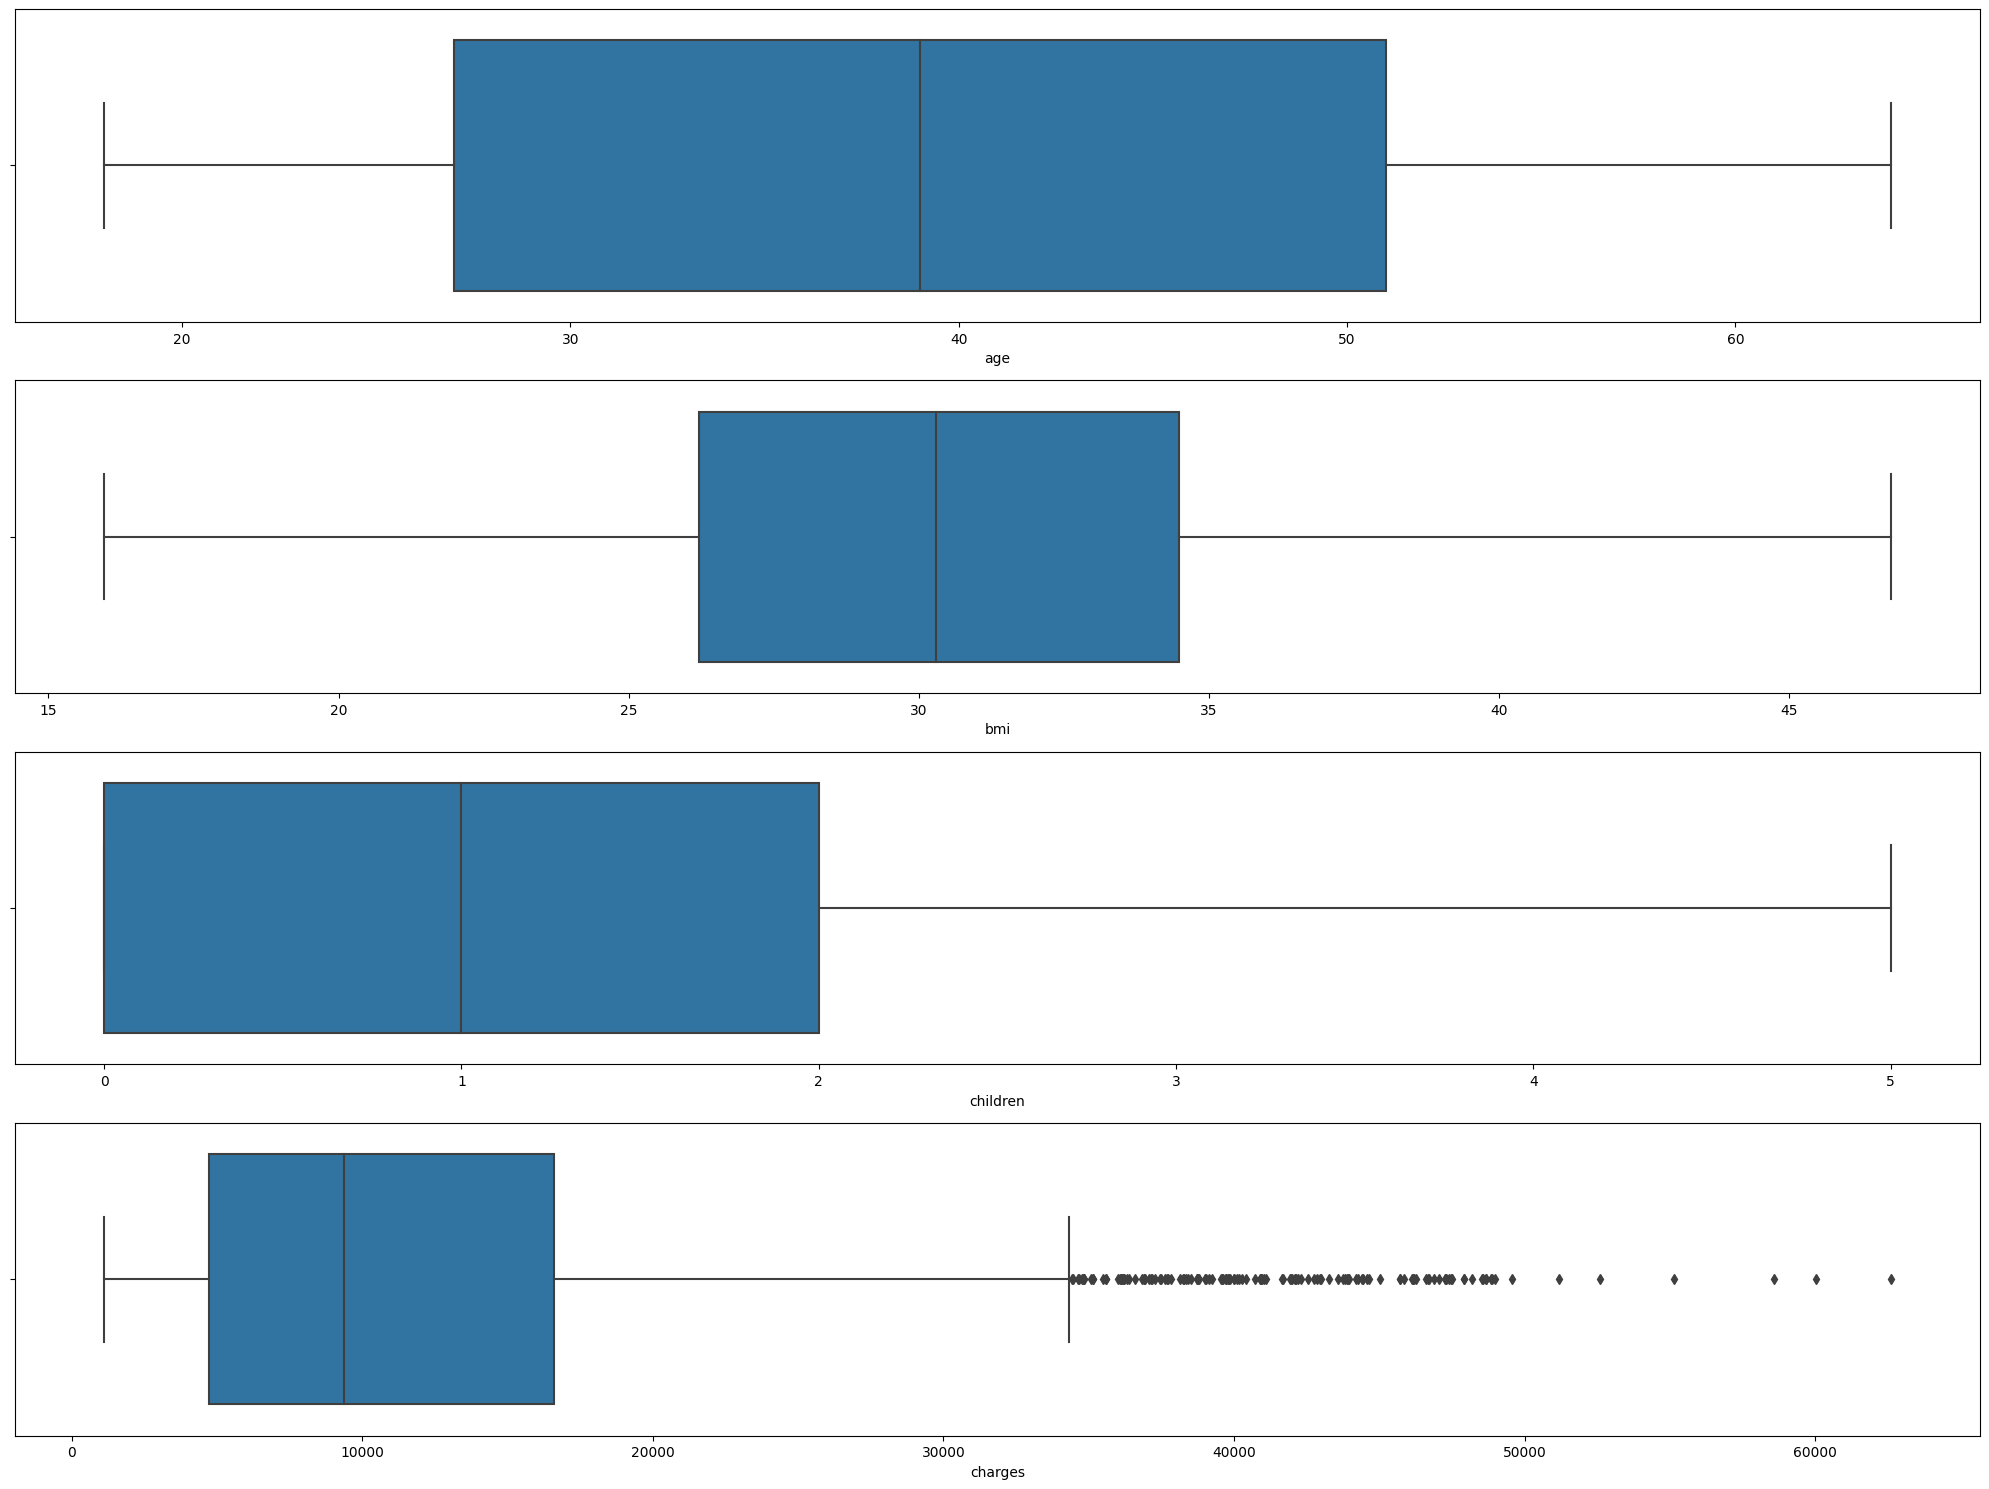

In [32]:
df_bmi_numericas = df_bmi.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_bmi_numericas.columns)):
    sns.boxplot(x=df_bmi_numericas.columns[i], data=df_bmi_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

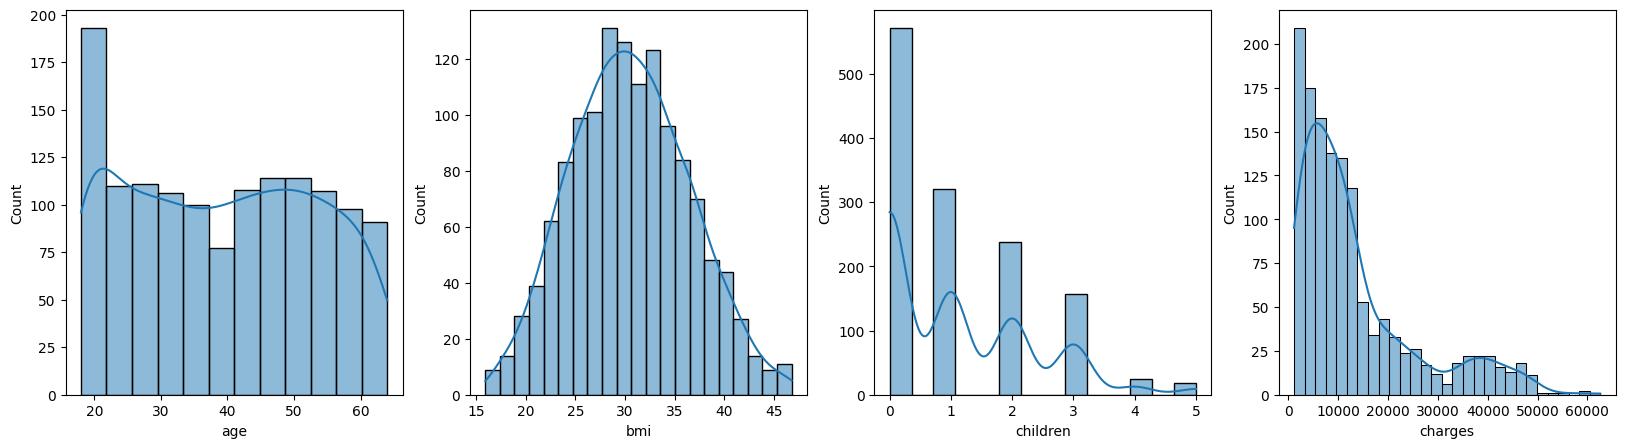

In [33]:
fig, ax = plt.subplots(1,4, figsize = (20,5))

ax = ax.flat
for i, columna in enumerate(df_bmi_numericas.columns):
    sns.histplot(data = df_bmi_numericas, x = columna, kde = True, ax = ax[i])
    
#fig.delaxes(ax[-1])
plt.show()

pese a retirando los outliers de `bmi`, sigo teniendo muchos valores anómalos de `charges`. voy a examinar las variables categóricas.

In [34]:
df_cate_sex = df_bmi.groupby('sex')['charges'].mean().reset_index()
df_cate_sex.head()

,sex,charges
0,female,12445.742535
1,male,13966.338394


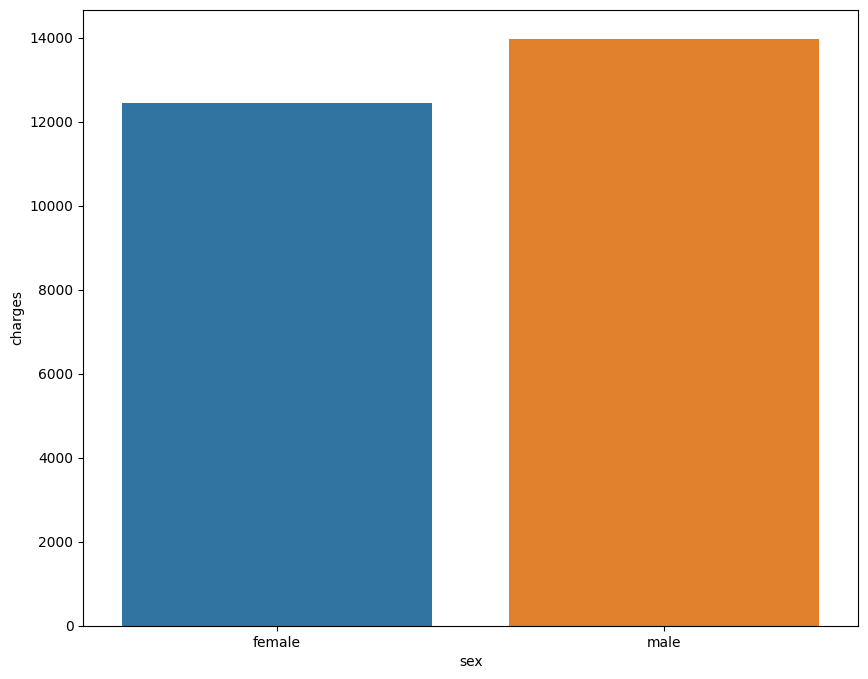

In [35]:
sns.barplot(data=df_cate_sex, x = 'sex', y = 'charges');

In [36]:
df_cate_smoker = df_bmi.groupby('smoker')['charges'].mean().reset_index()
df_cate_smoker.head()

,smoker,charges
0,no,8442.167174
1,yes,31835.343855


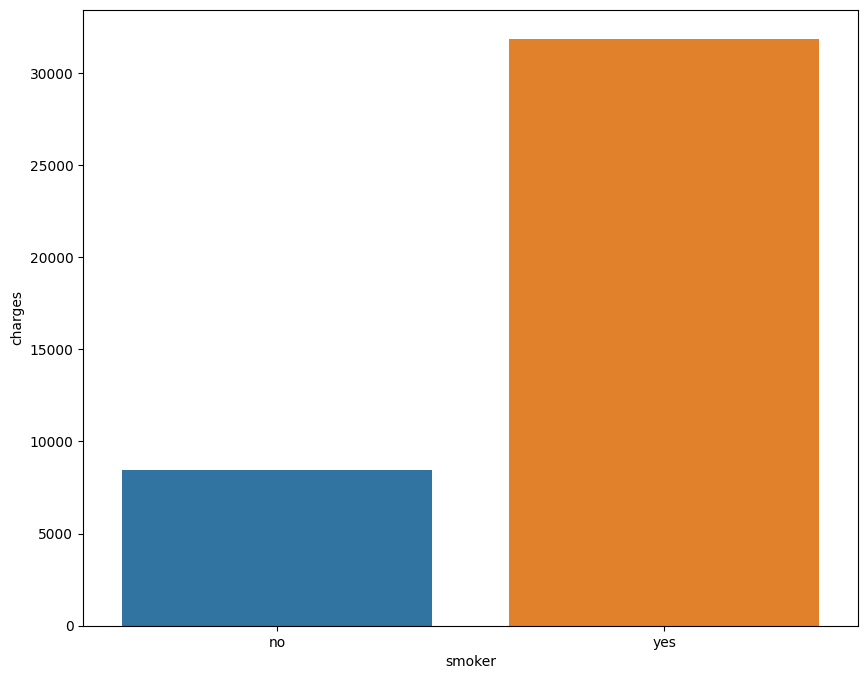

In [37]:
sns.barplot(data=df_cate_smoker, x = 'smoker', y = 'charges');

In [38]:
df_cate_smoker = df_bmi.groupby('region')['charges'].mean().reset_index()
df_cate_smoker.head()

,region,charges
0,northeast,13418.686248
1,northwest,12417.575374
2,southeast,14629.137993
3,southwest,12242.719557


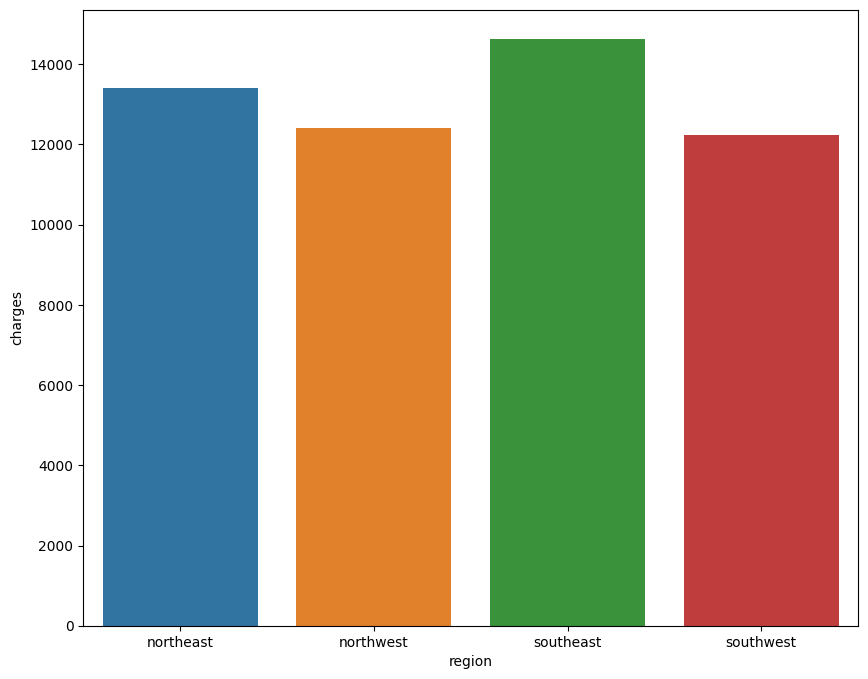

In [39]:
sns.barplot(data=df_cate_smoker, x = 'region', y = 'charges');

sigue ocurriendo lo mismo -- la media de `charges` según los `smokers` sigue siendo muy alta para los fumadores.

## hipótesis 02: fumadores o no fumadores

In [40]:
df_smoker = df[df['smoker'] == 'yes']
df_non_smoker = df[df['smoker'] == 'no']
df_smoker.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


In [41]:
df_non_smoker.head(1)

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.77,1,no,southeast,1725.5523


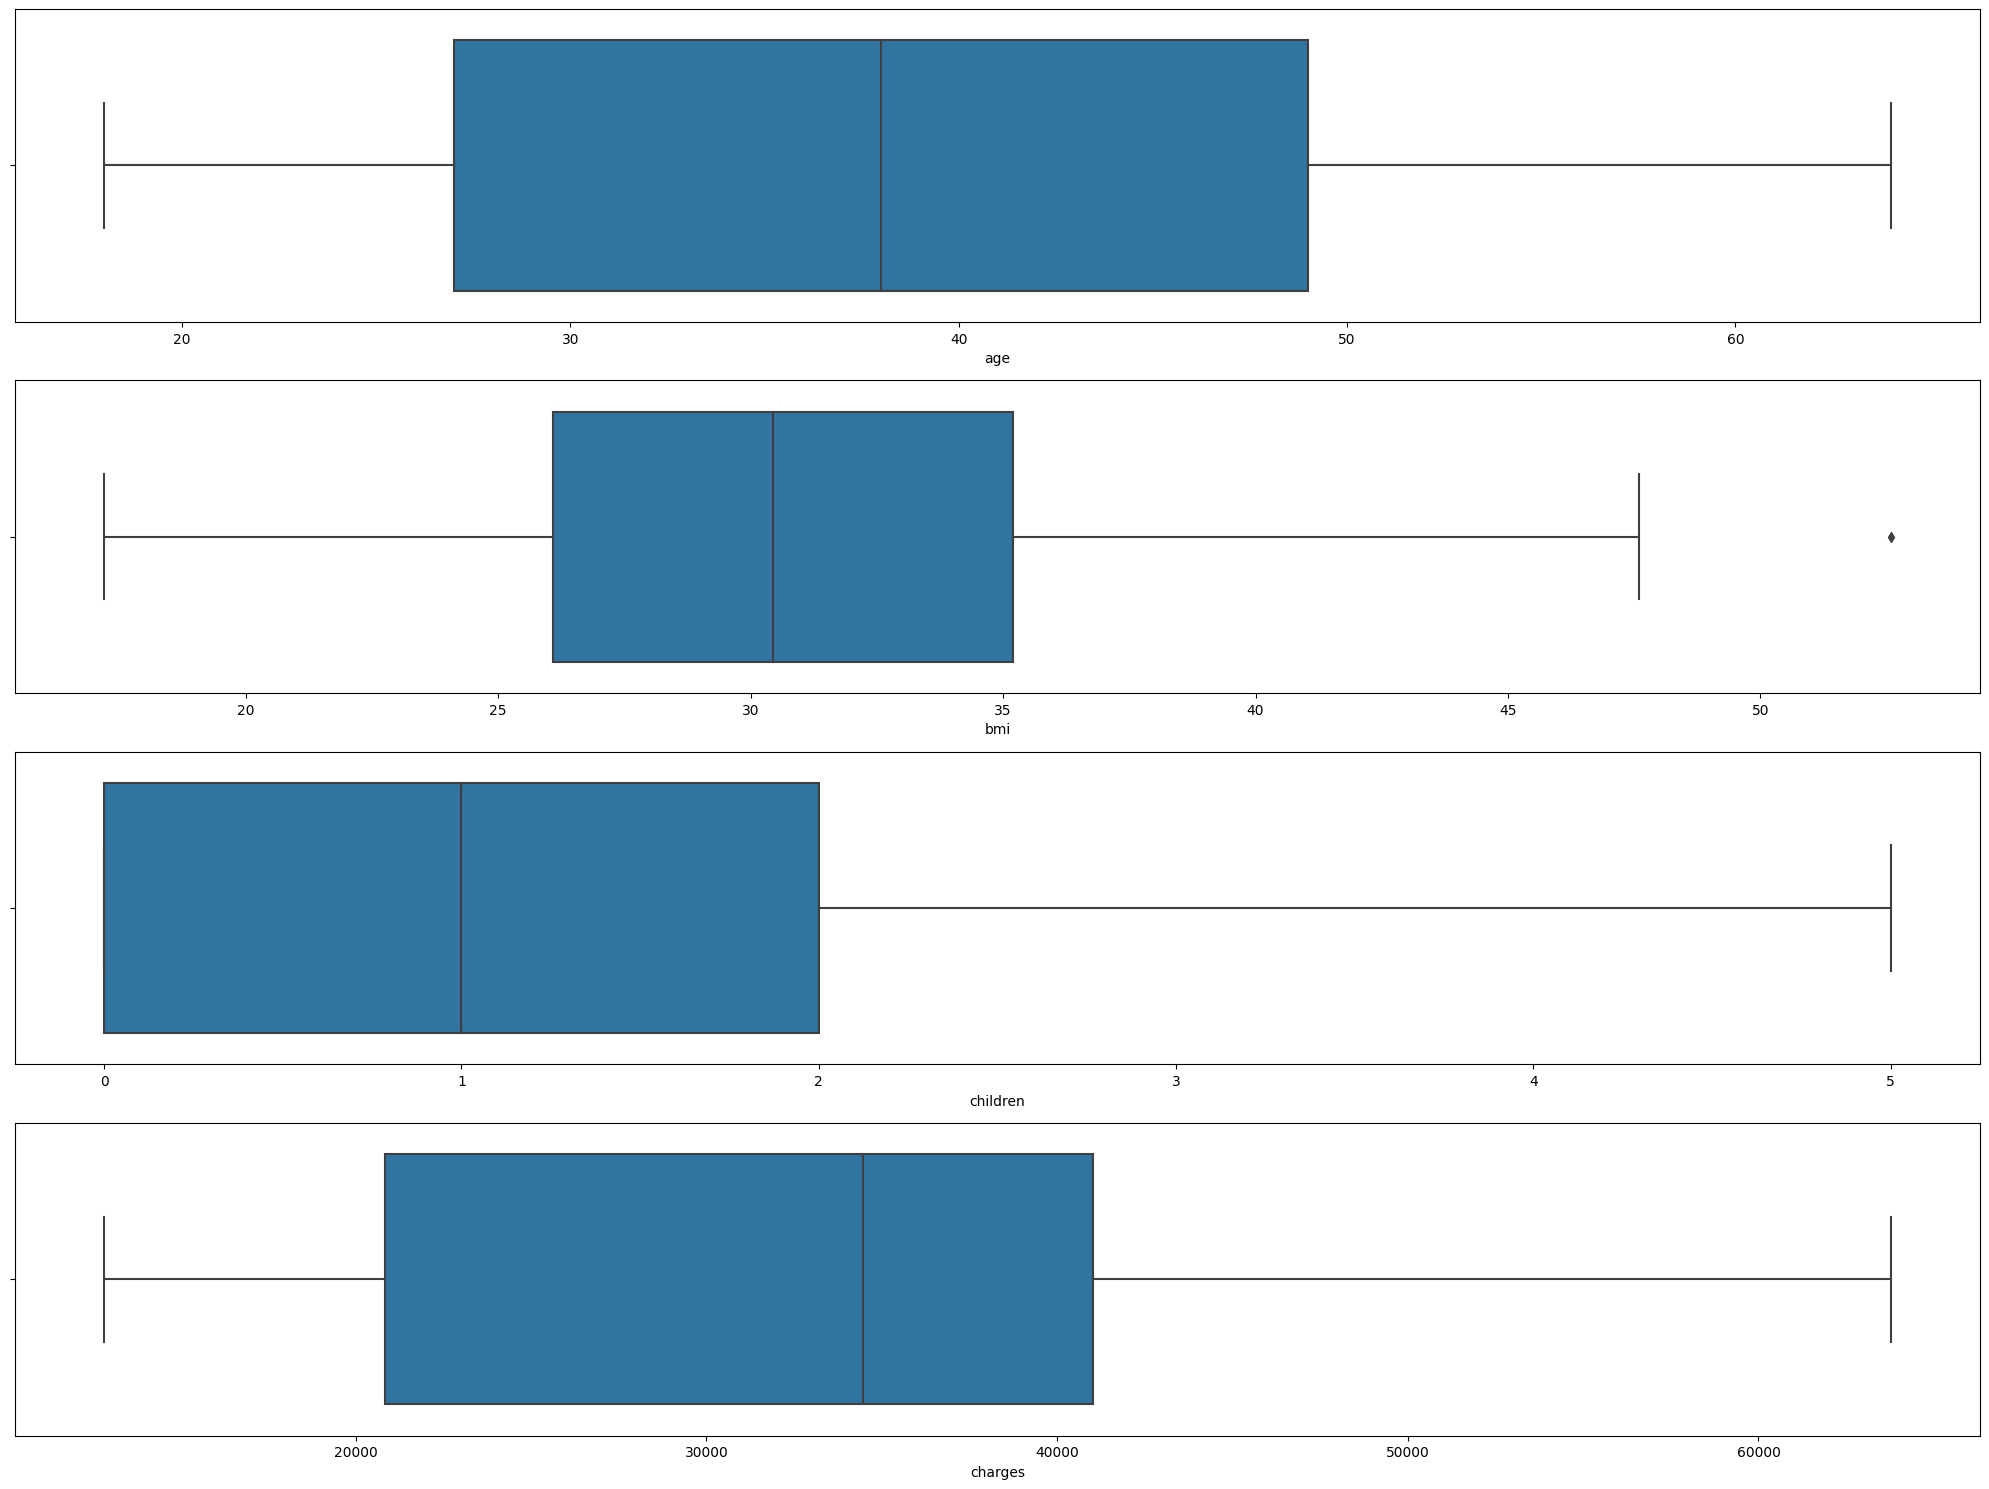

In [42]:
df_smoker_numericas = df_smoker.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_smoker_numericas.columns)):
    sns.boxplot(x=df_smoker_numericas.columns[i], data=df_smoker_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

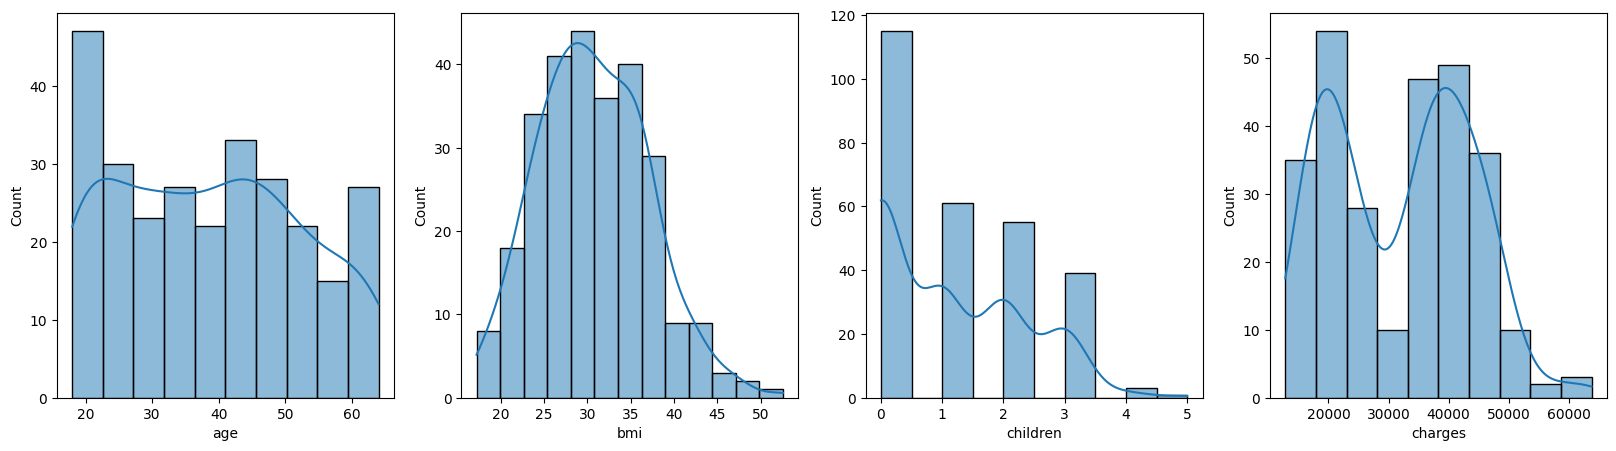

In [43]:
fig, ax = plt.subplots(1,4, figsize = (20,5))

ax = ax.flat
for i, columna in enumerate(df_smoker_numericas.columns):
    sns.histplot(data = df_smoker_numericas, x = columna, kde = True, ax = ax[i])
    
#fig.delaxes(ax[-1])
plt.show()

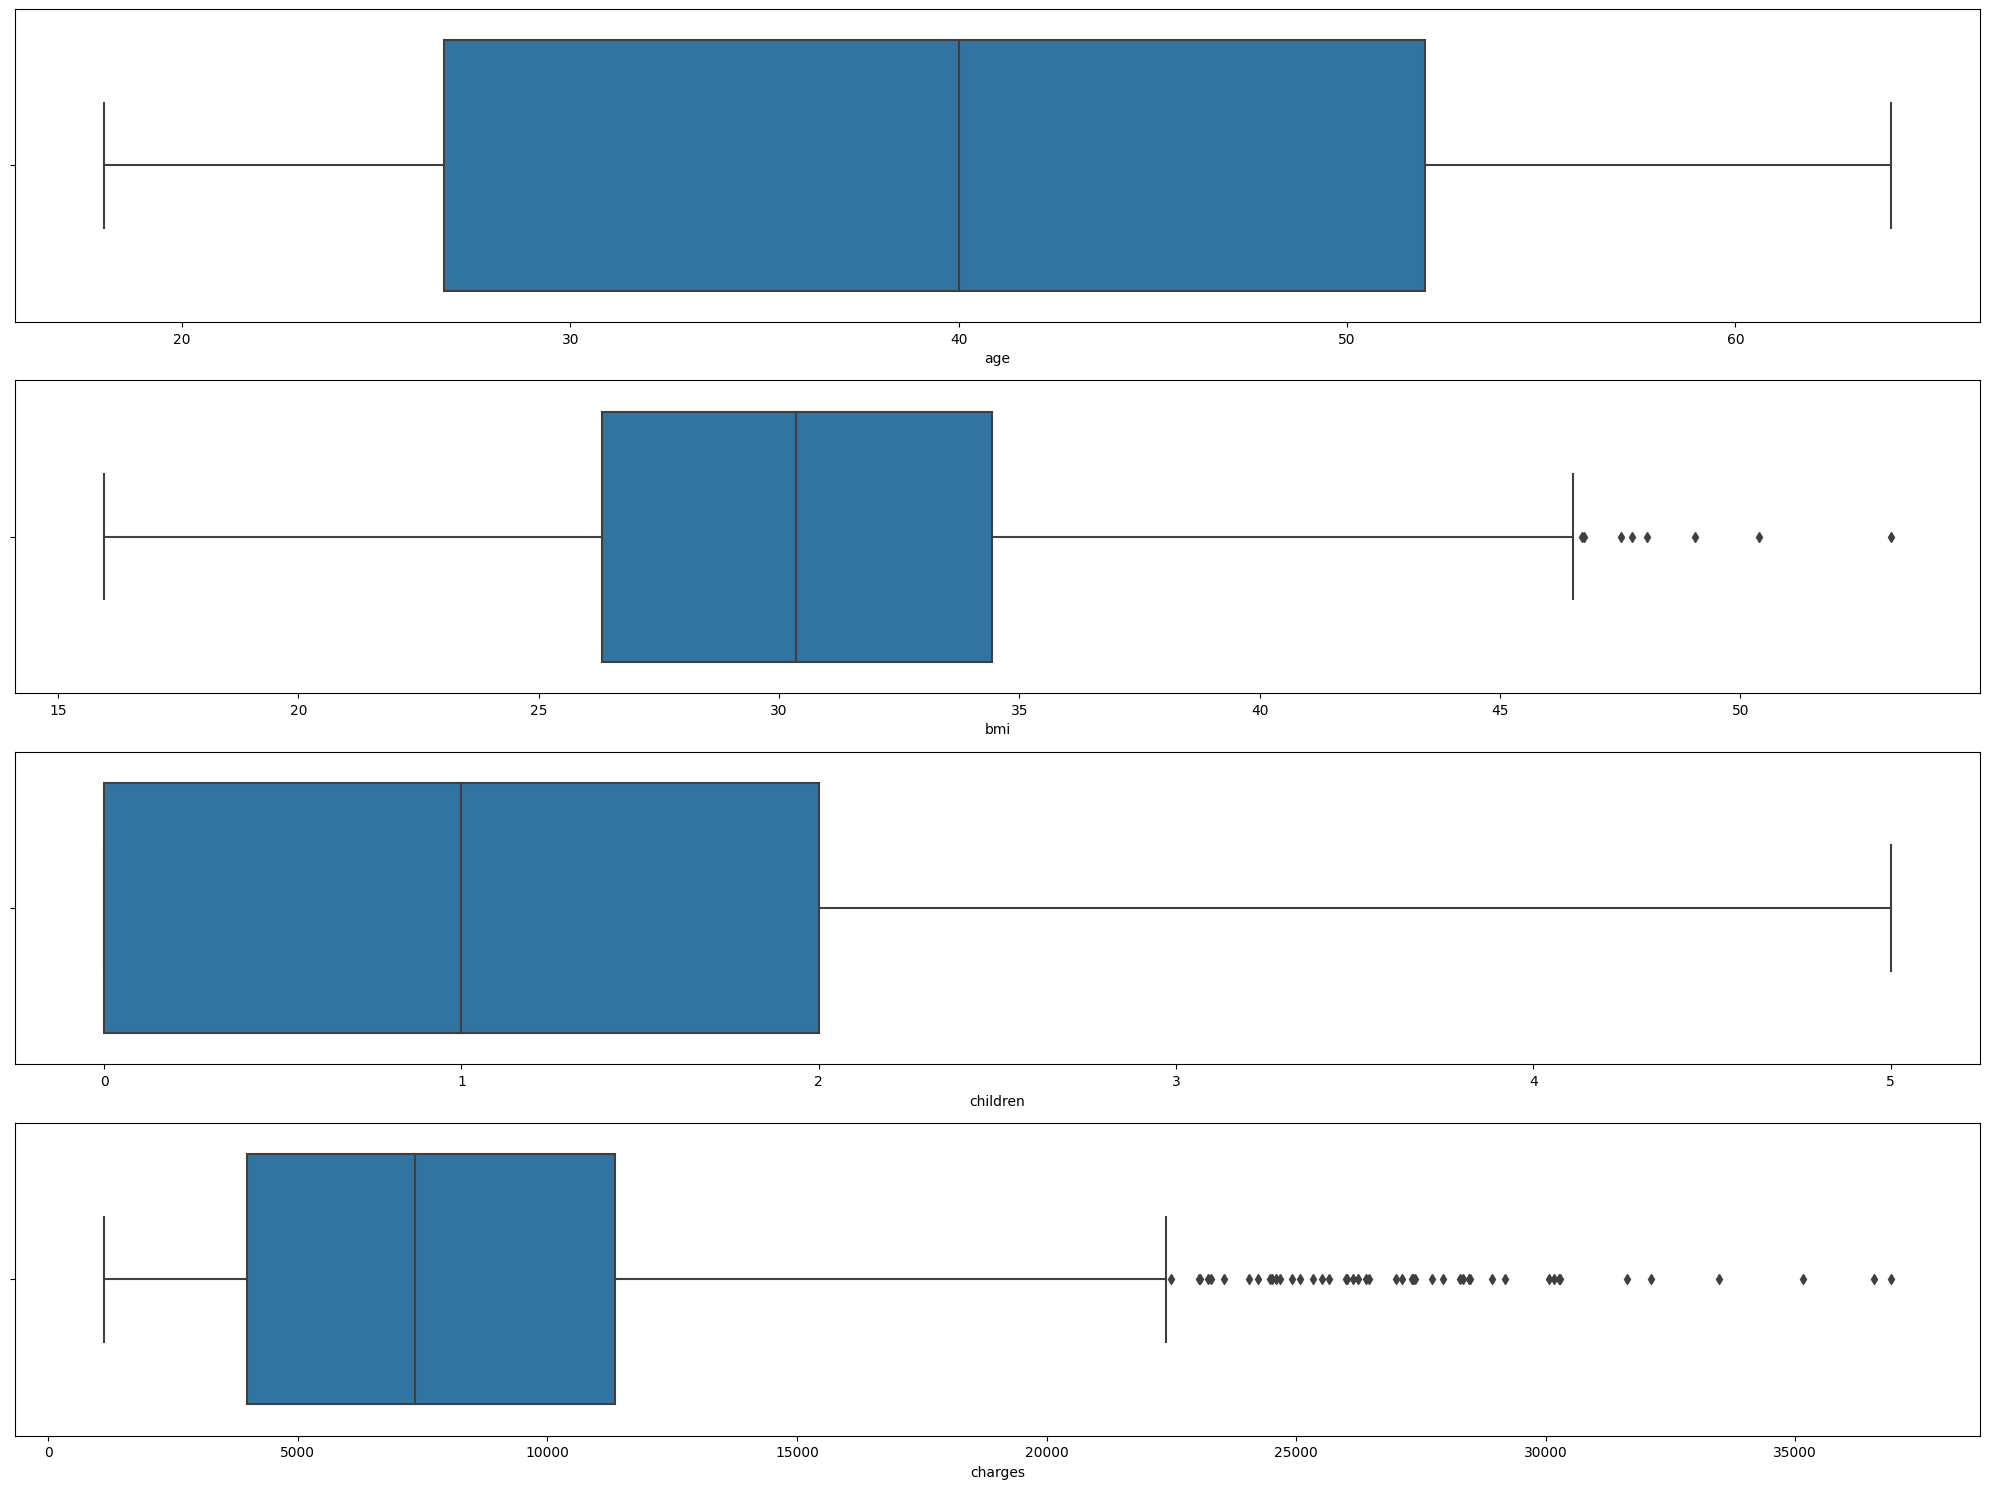

In [44]:
df_non_smoker_numericas = df_non_smoker.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_non_smoker_numericas.columns)):
    sns.boxplot(x=df_non_smoker_numericas.columns[i], data=df_non_smoker_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

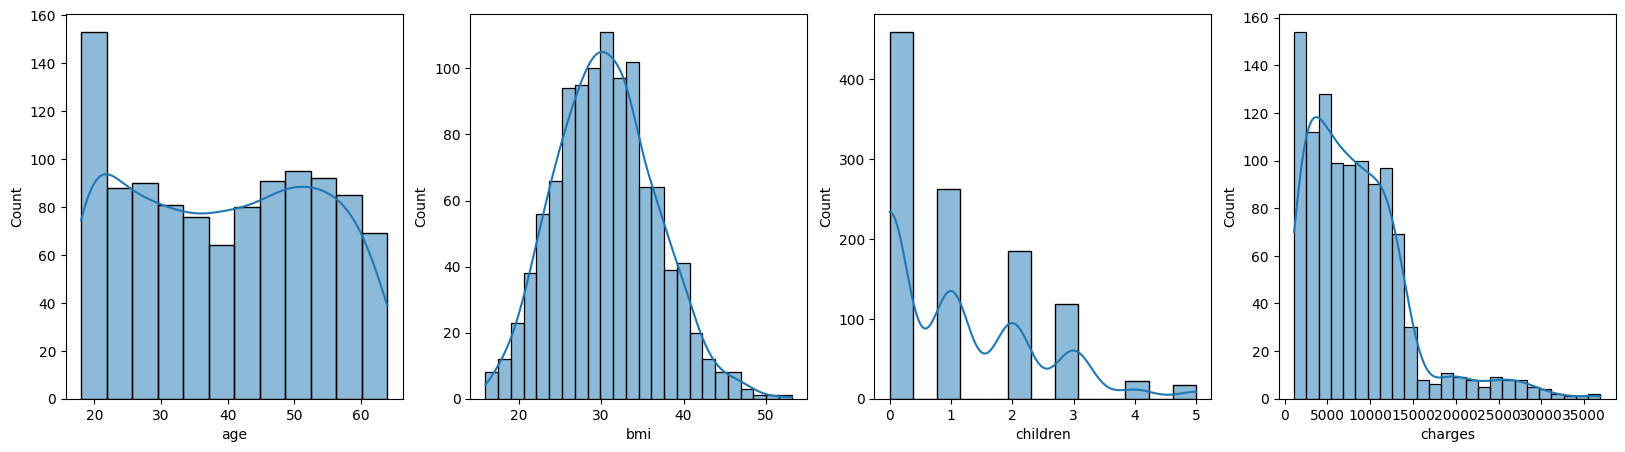

In [45]:
fig, ax = plt.subplots(1,4, figsize = (20,5))

ax = ax.flat
for i, columna in enumerate(df_non_smoker_numericas.columns):
    sns.histplot(data = df_non_smoker_numericas, x = columna, kde = True, ax = ax[i])
    
#fig.delaxes(ax[-1])
plt.show()


Los valores de smokers parece que se quedan sin outliers. Sin embargo, vamos a ver si se pueden quitar los outliers de non-smokers para poder tener una mejor distribución en `charges`.

## hipotesis 03: charges

In [80]:
indices_charges = dic_outliers['charges']
print(len(indices_charges), df_non_smoker.shape)

139 (1061, 11)


In [81]:
df_charges_out = df_non_smoker.loc[indices_charges,:]
df_charges = df_non_smoker.loc[~df_non_smoker.index.isin(indices_charges), :]
print(df_charges.shape, df_charges_out.shape)

KeyError: "None of [Int64Index([  14,   19,   23,   29,   30,   34,   38,   39,   49,   53,\n            ...\n            1241, 1249, 1284, 1288, 1291, 1300, 1301, 1303, 1313, 1323],\n           dtype='int64', length=139)] are in the [index]"

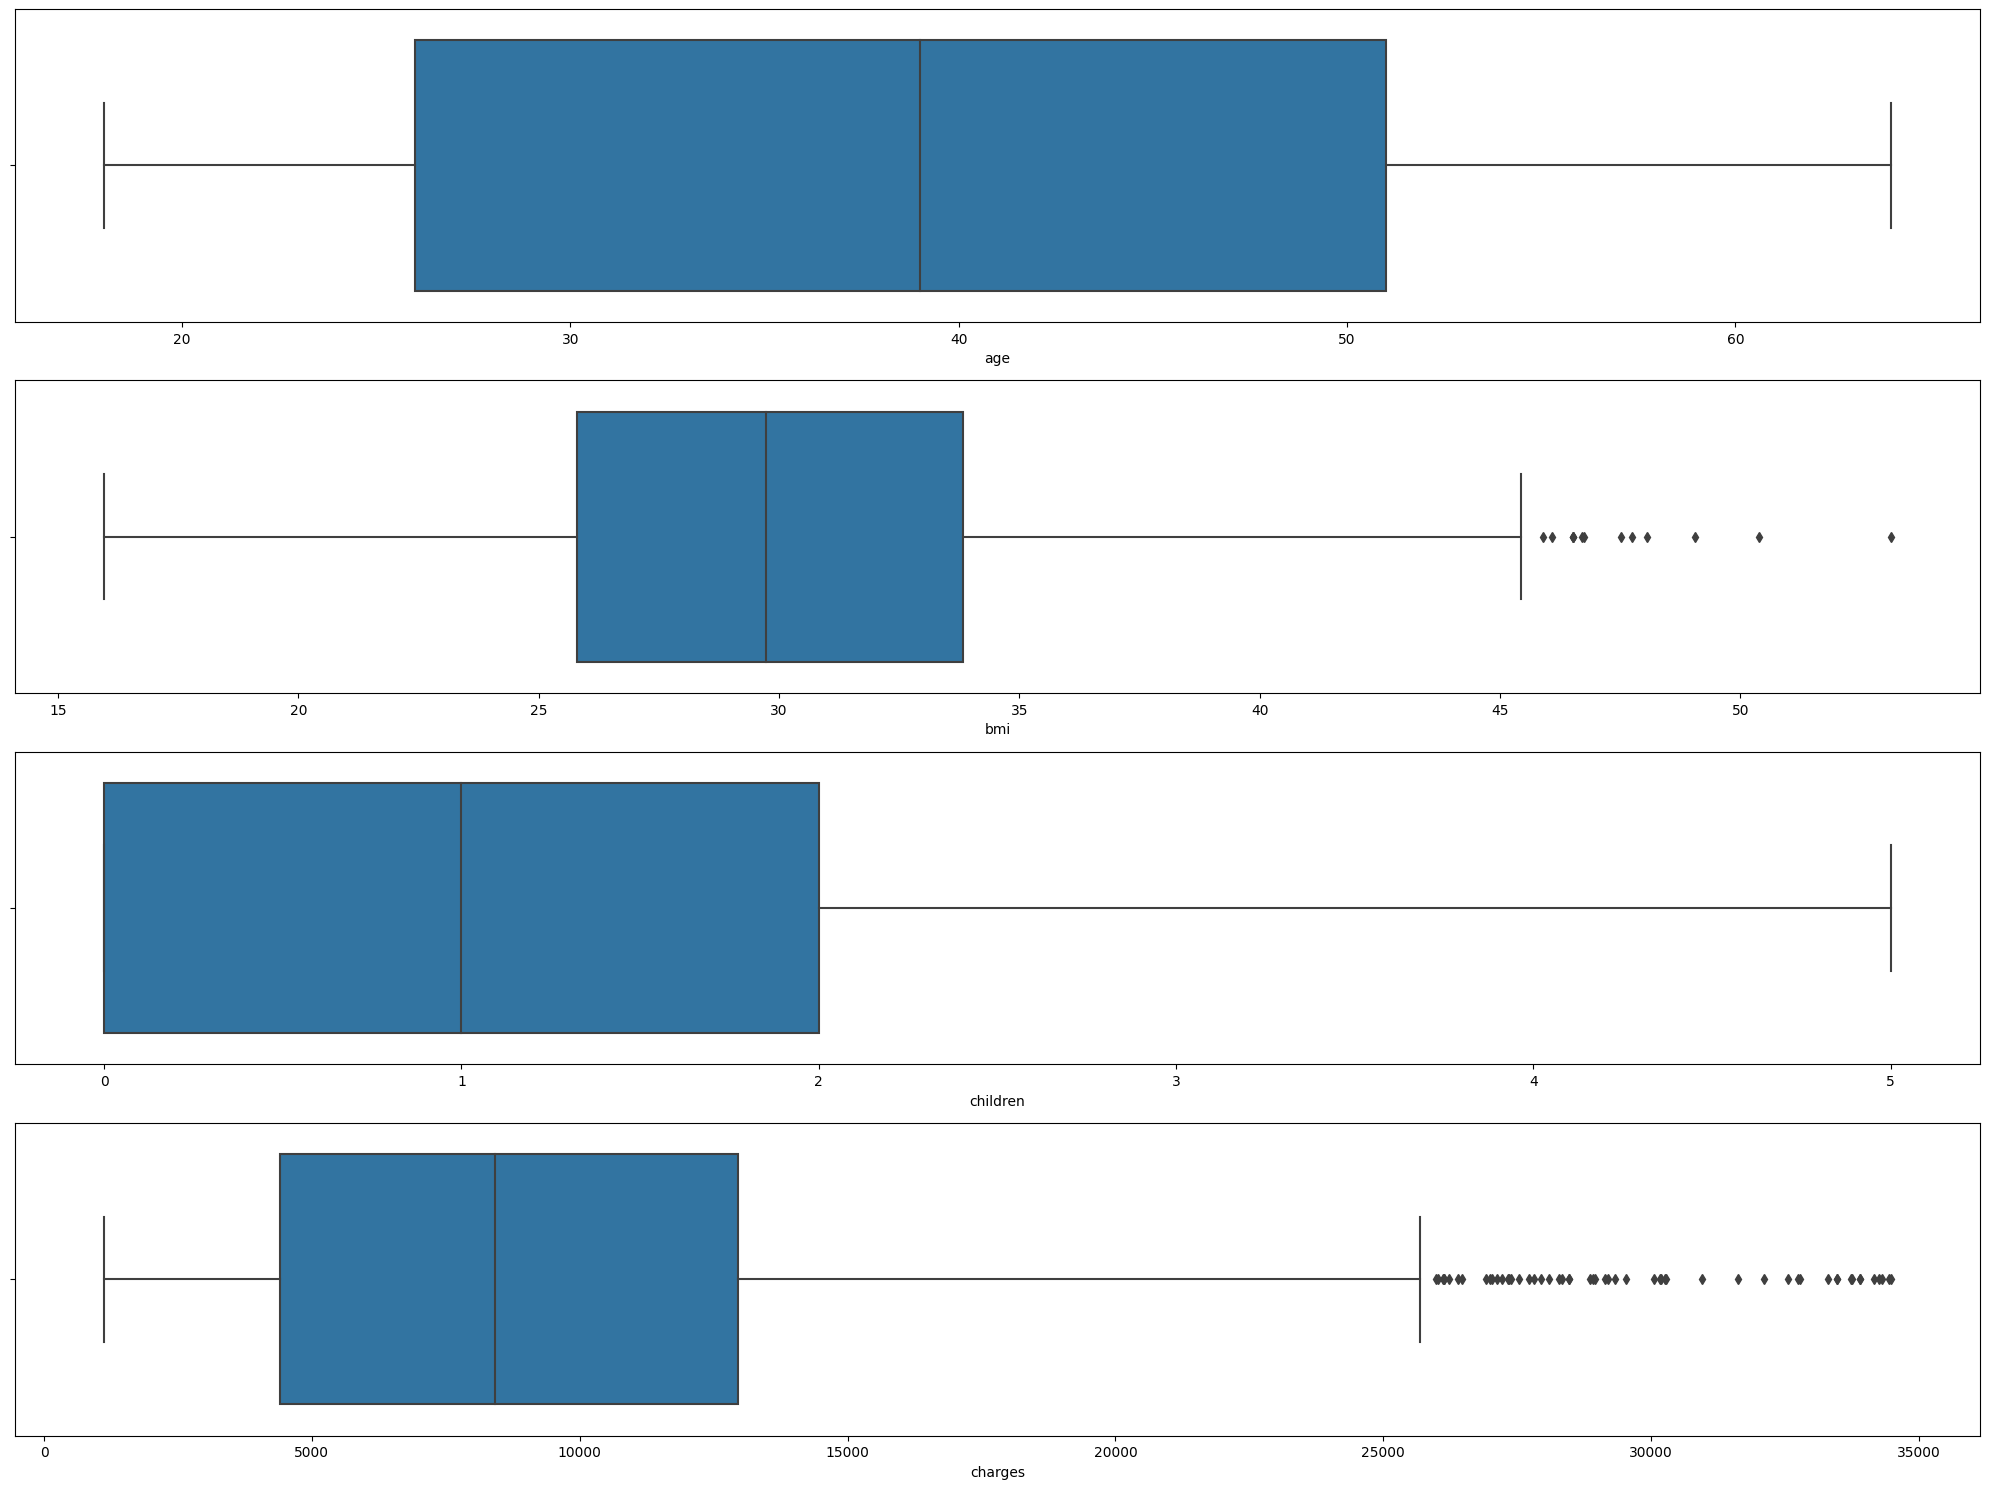

In [48]:
df_charges_numericas = df_charges.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_charges_numericas.columns)):
    sns.boxplot(x=df_charges_numericas.columns[i], data=df_charges_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

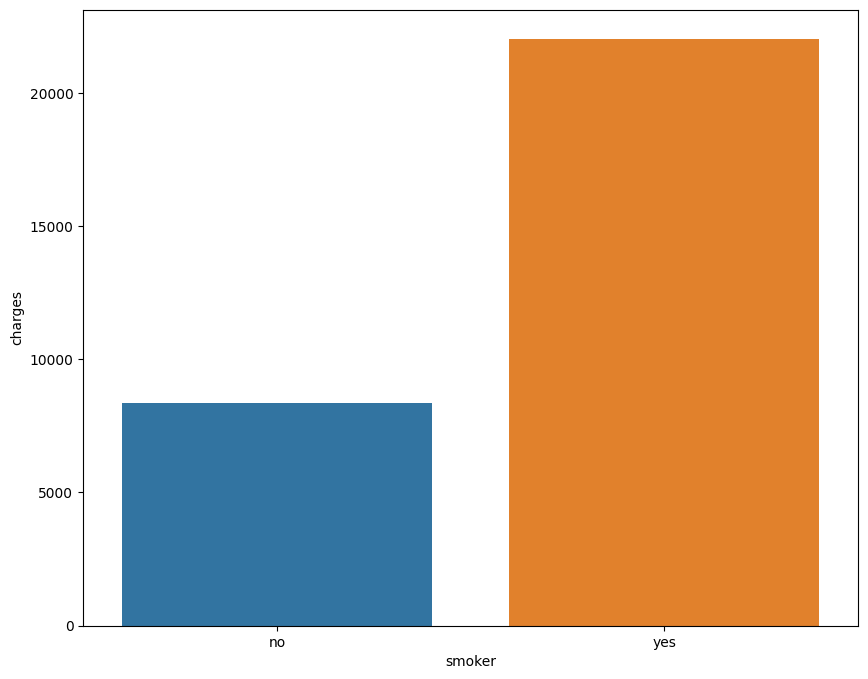

In [49]:
df_cate_charges = df_charges.groupby('smoker')['charges'].mean().reset_index()
sns.barplot(data=df_cate_charges, x = 'smoker', y = 'charges');

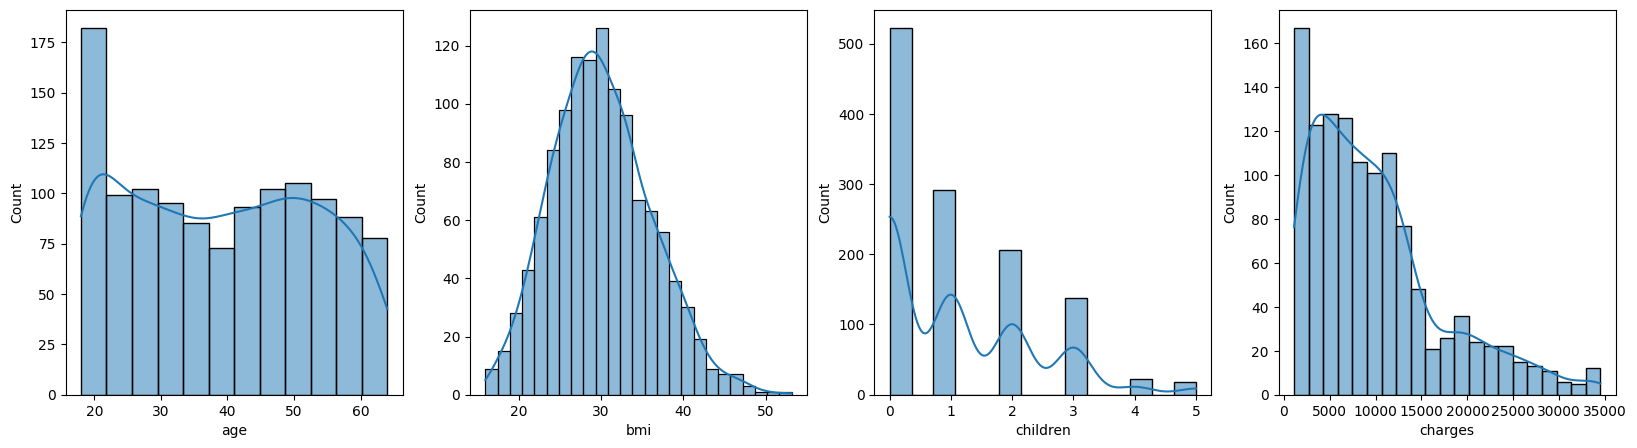

In [50]:
fig, ax = plt.subplots(1,4, figsize = (20,5))

ax = ax.flat
for i, columna in enumerate(df_charges_numericas.columns):
    sns.histplot(data = df_charges_numericas, x = columna, kde = True, ax = ax[i])
    
#fig.delaxes(ax[-1])
plt.show()


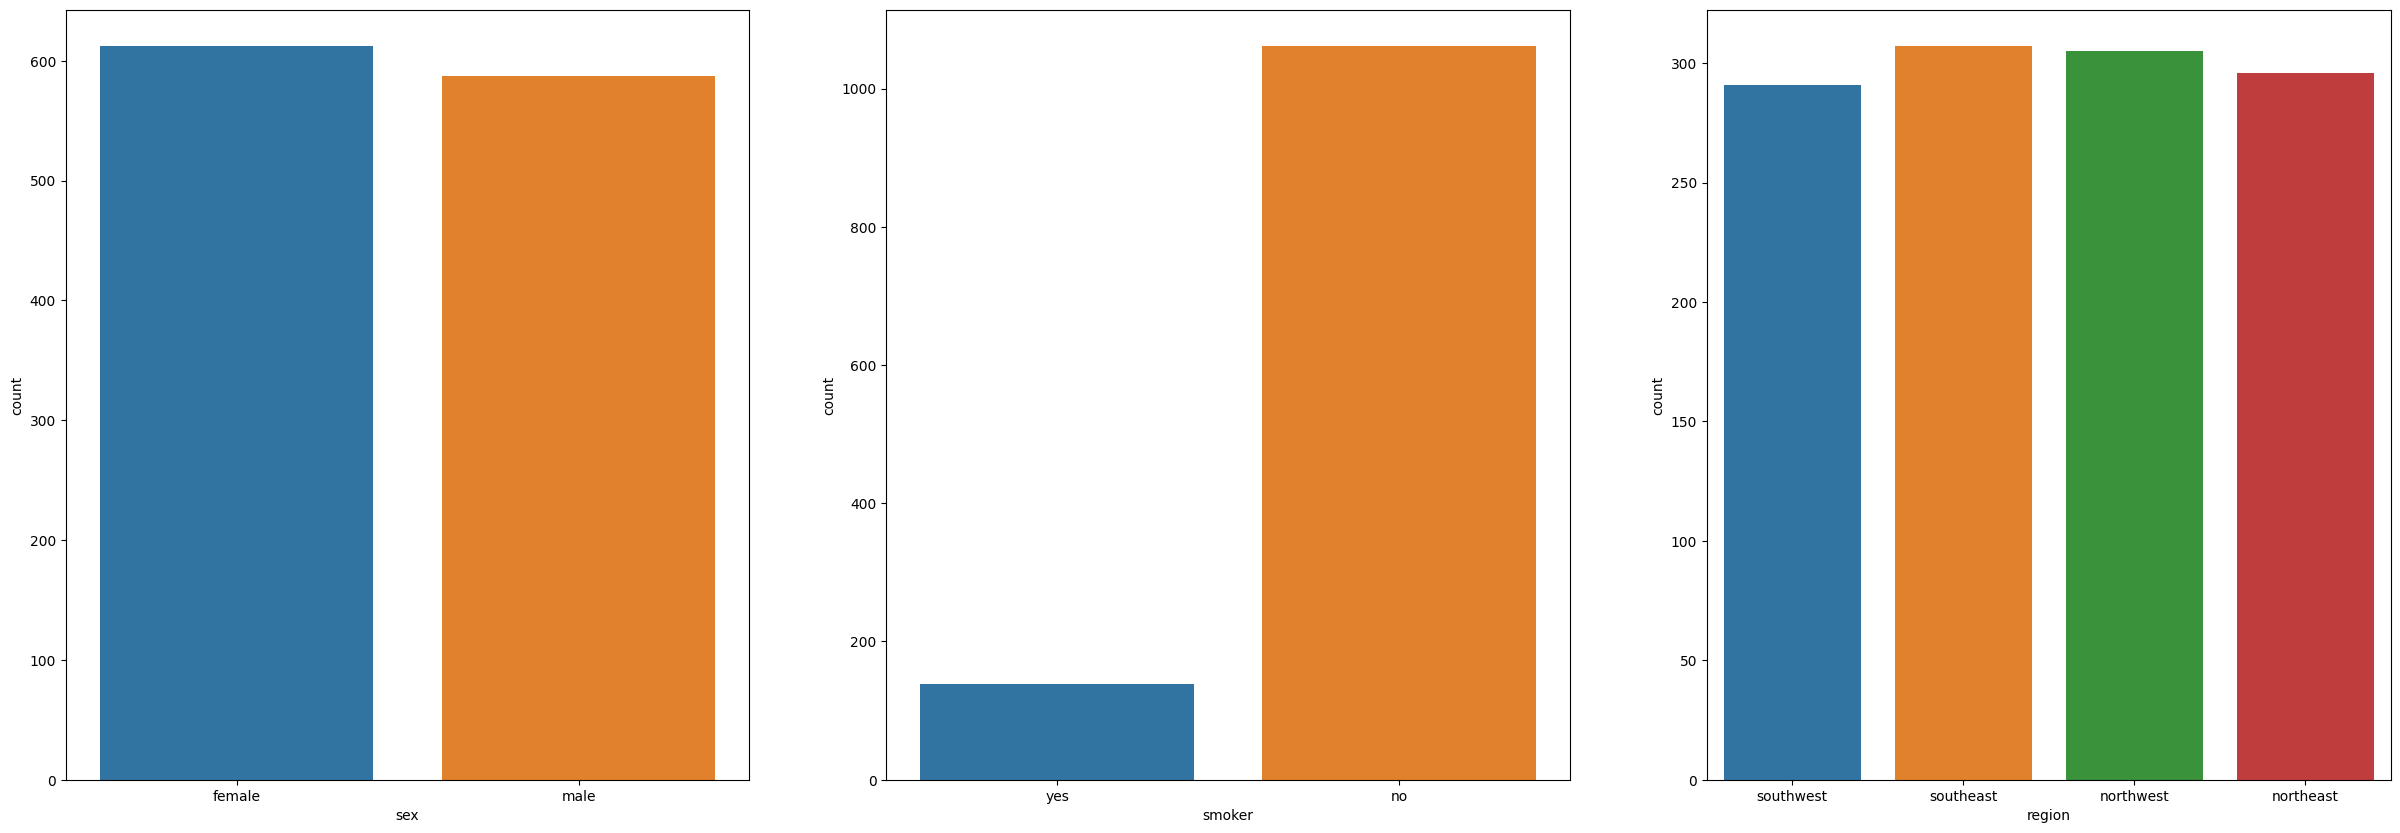

In [51]:
df_charges_categoricas = df_charges.select_dtypes(include='object')

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

axes = axes.flat

for i, columna in enumerate(df_charges_categoricas.columns):
    sns.countplot(data = df_charges, 
                  x = columna, 
                  ax = axes[i]);

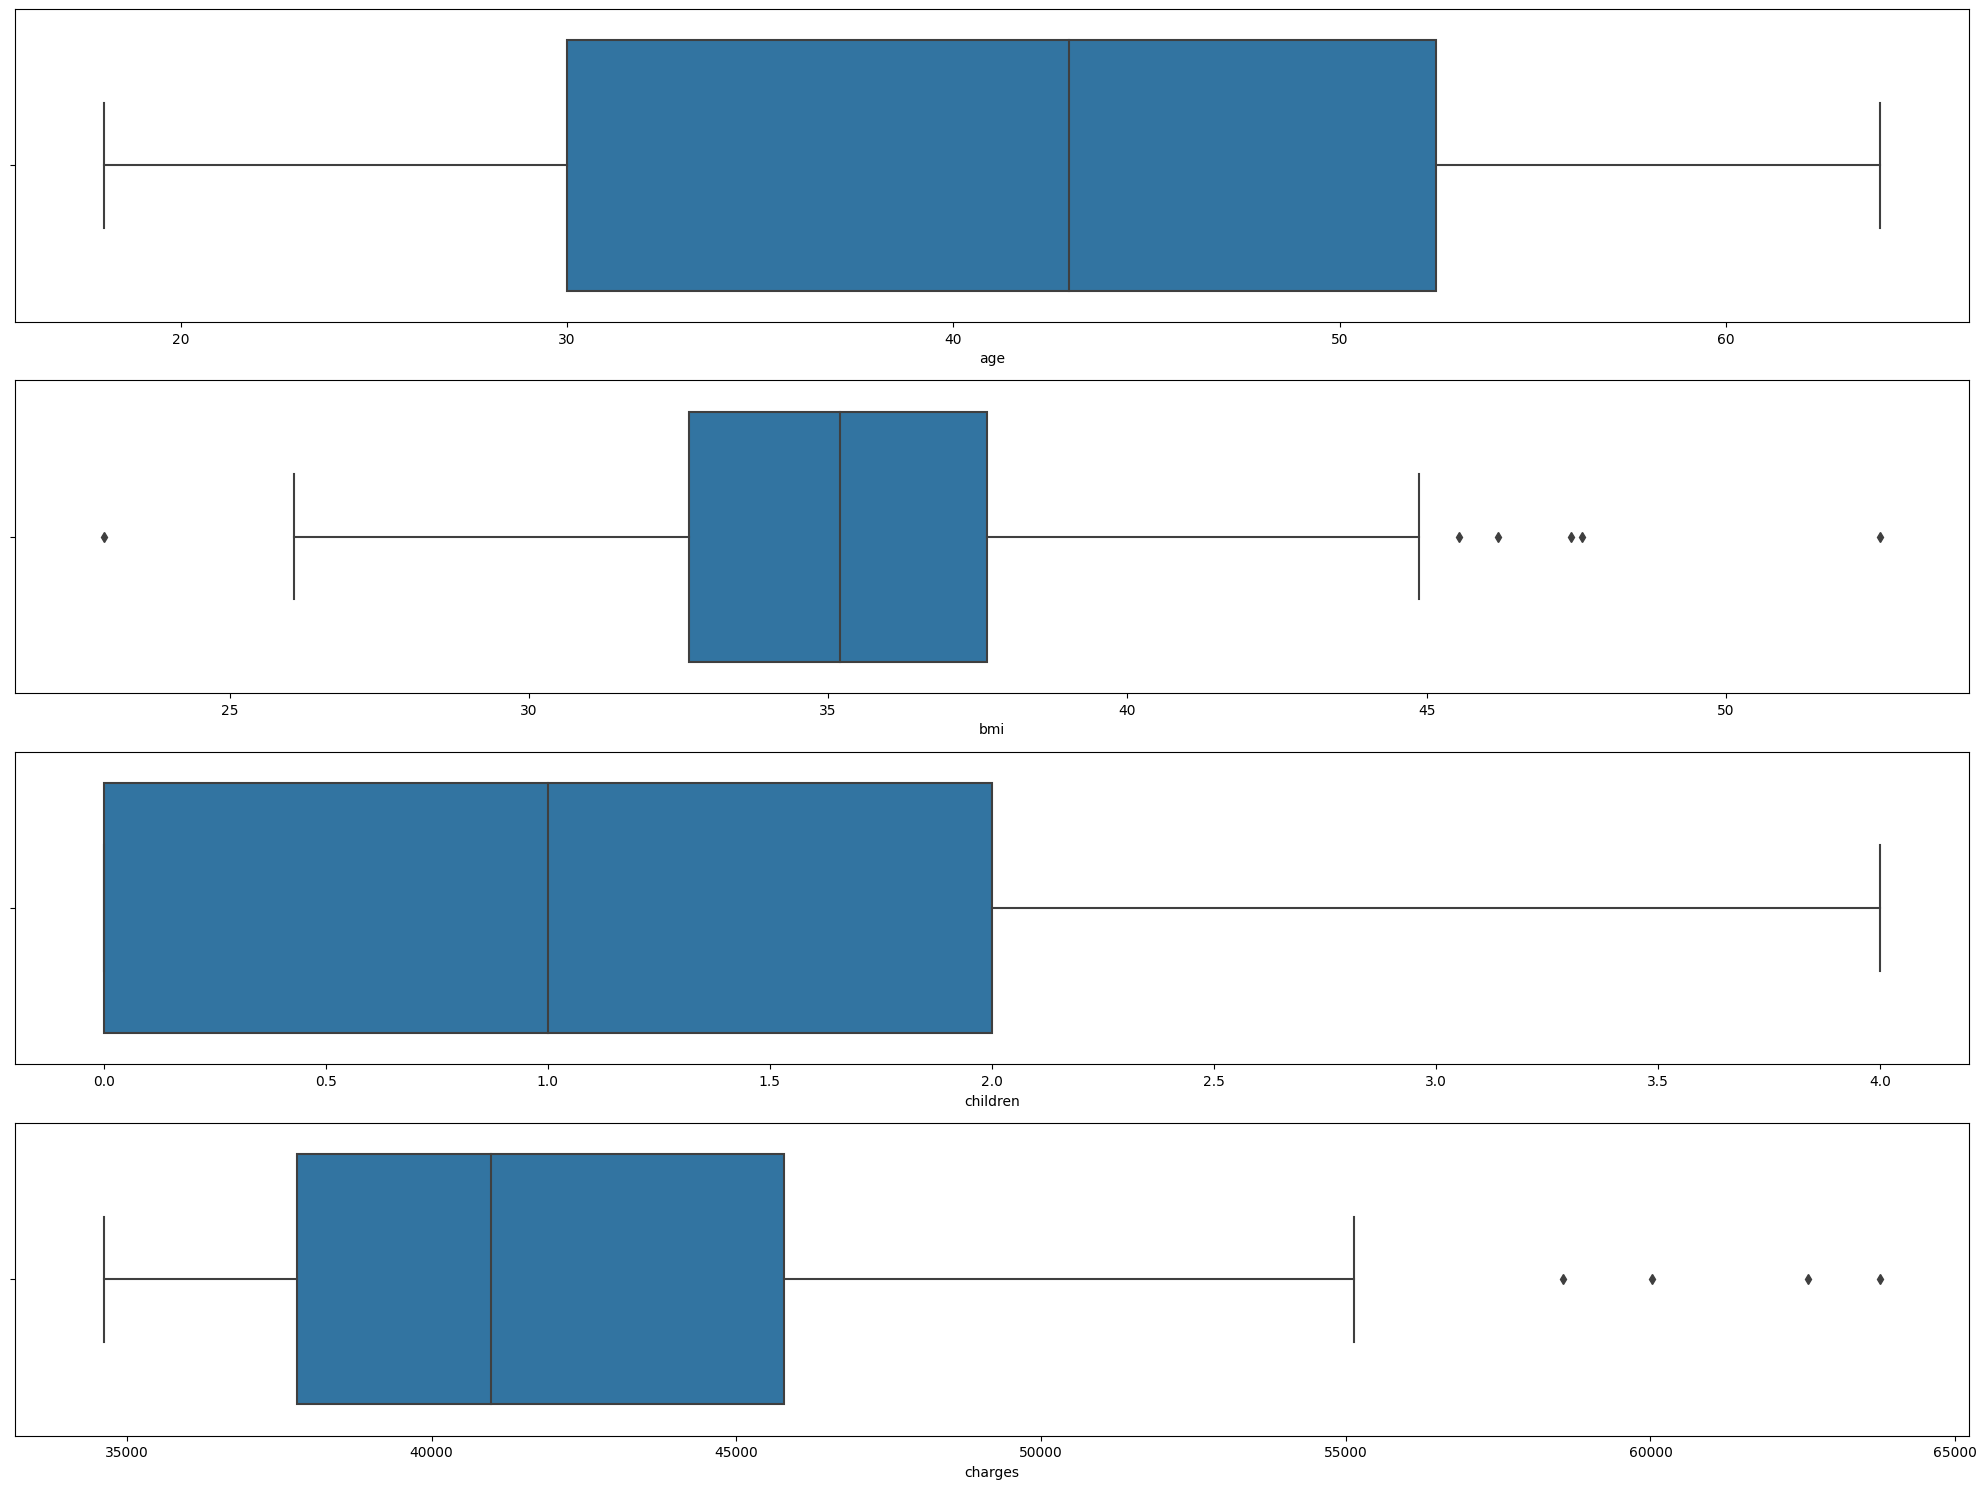

In [52]:
df_charges_out_numericas = df_charges_out.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_charges_out_numericas.columns)):
    sns.boxplot(x=df_charges_out_numericas.columns[i], data=df_charges_out_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

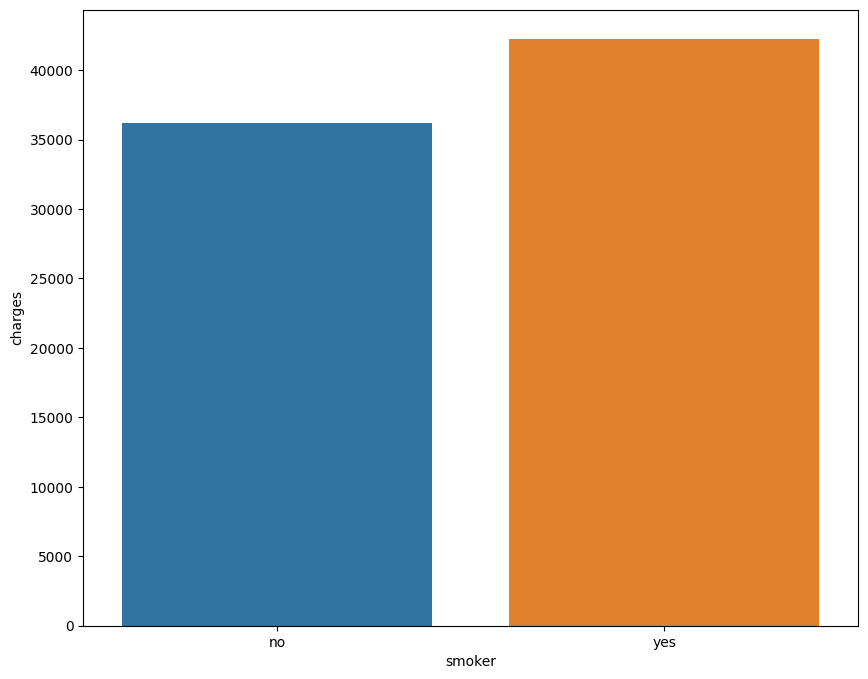

In [53]:
df_cate_charges_out = df_charges_out.groupby('smoker')['charges'].mean().reset_index()
sns.barplot(data=df_cate_charges_out, x = 'smoker', y = 'charges');

el df de los outliers de `charges` parece que ha mejorado; vamos a probar a separar además los no outliers entre fumadores y no fumadores.

In [54]:
df_smoker = df_charges[df_charges['smoker'] == 'yes']
df_non_smoker = df_charges[df_charges['smoker'] == 'no']
df_smoker.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
52,48,male,28.00,1,yes,southwest,23568.2720
57,18,male,31.68,2,yes,southeast,34303.1672
58,53,female,22.88,1,yes,southeast,23244.7902


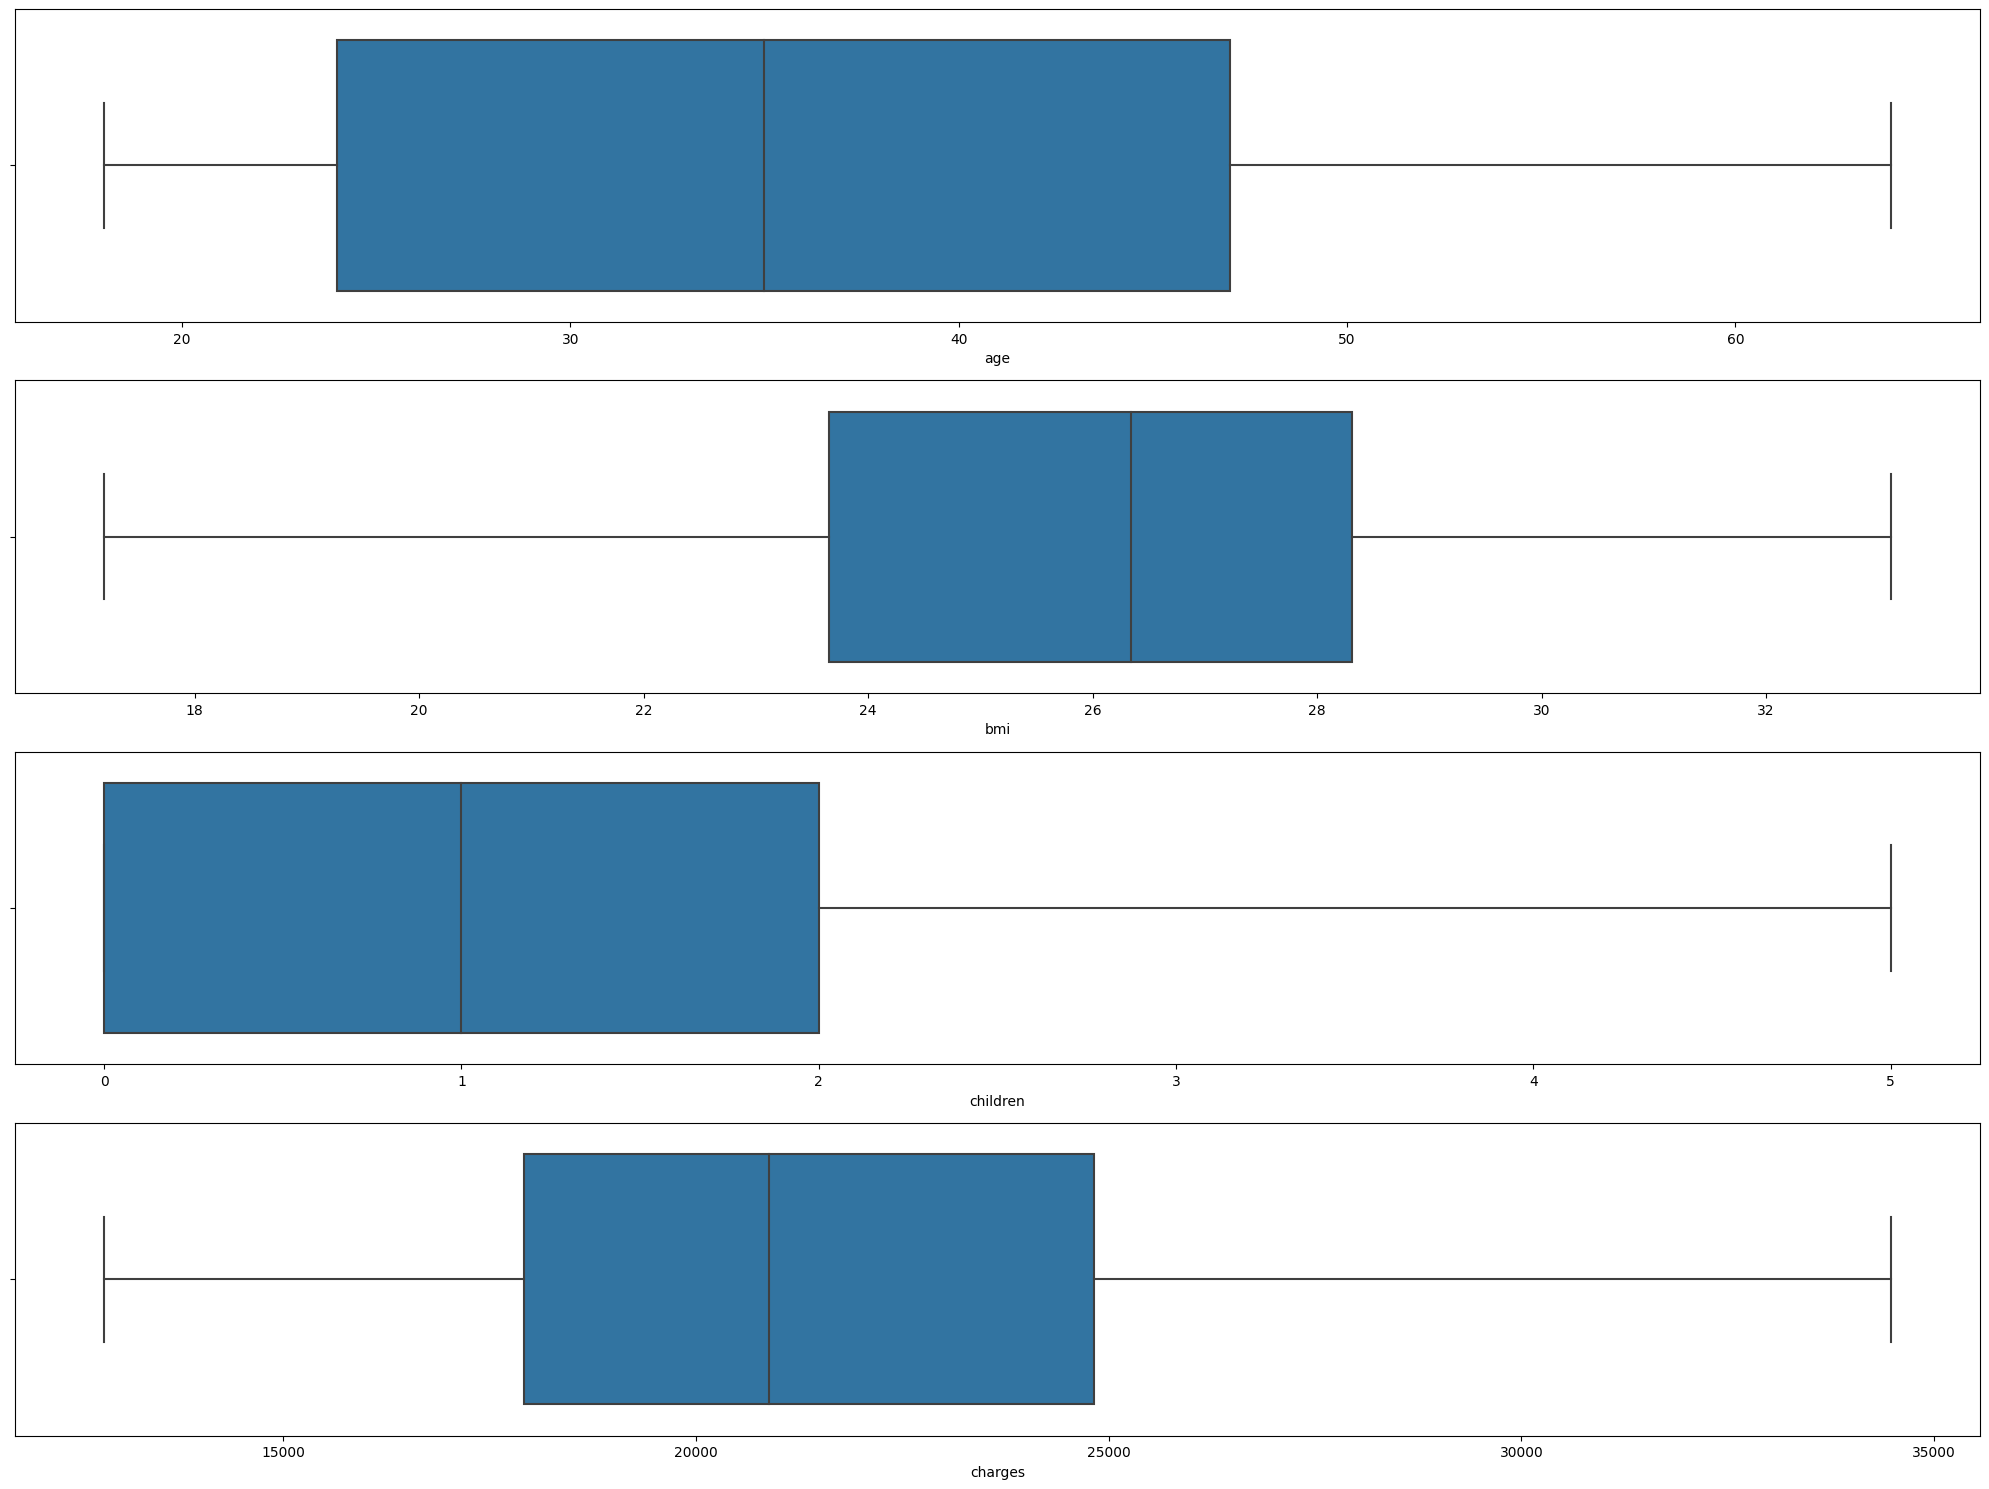

In [55]:
df_smoker_numericas = df_smoker.select_dtypes(include=np.number)

fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_smoker_numericas.columns)):
    sns.boxplot(x=df_smoker_numericas.columns[i], data=df_smoker_numericas, ax=ax[i])
plt.tight_layout()
plt.show();

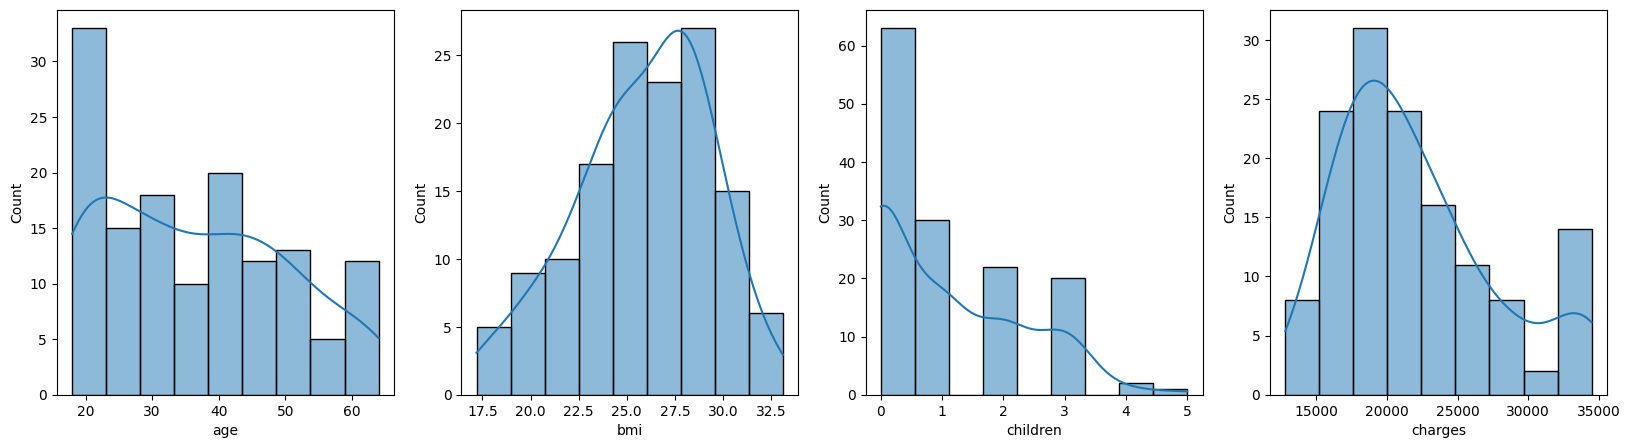

In [56]:
fig, ax = plt.subplots(1,4, figsize = (20,5))

ax = ax.flat
for i, columna in enumerate(df_smoker_numericas.columns):
    sns.histplot(data = df_smoker_numericas, x = columna, kde = True, ax = ax[i])
    
#fig.delaxes(ax[-1])
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

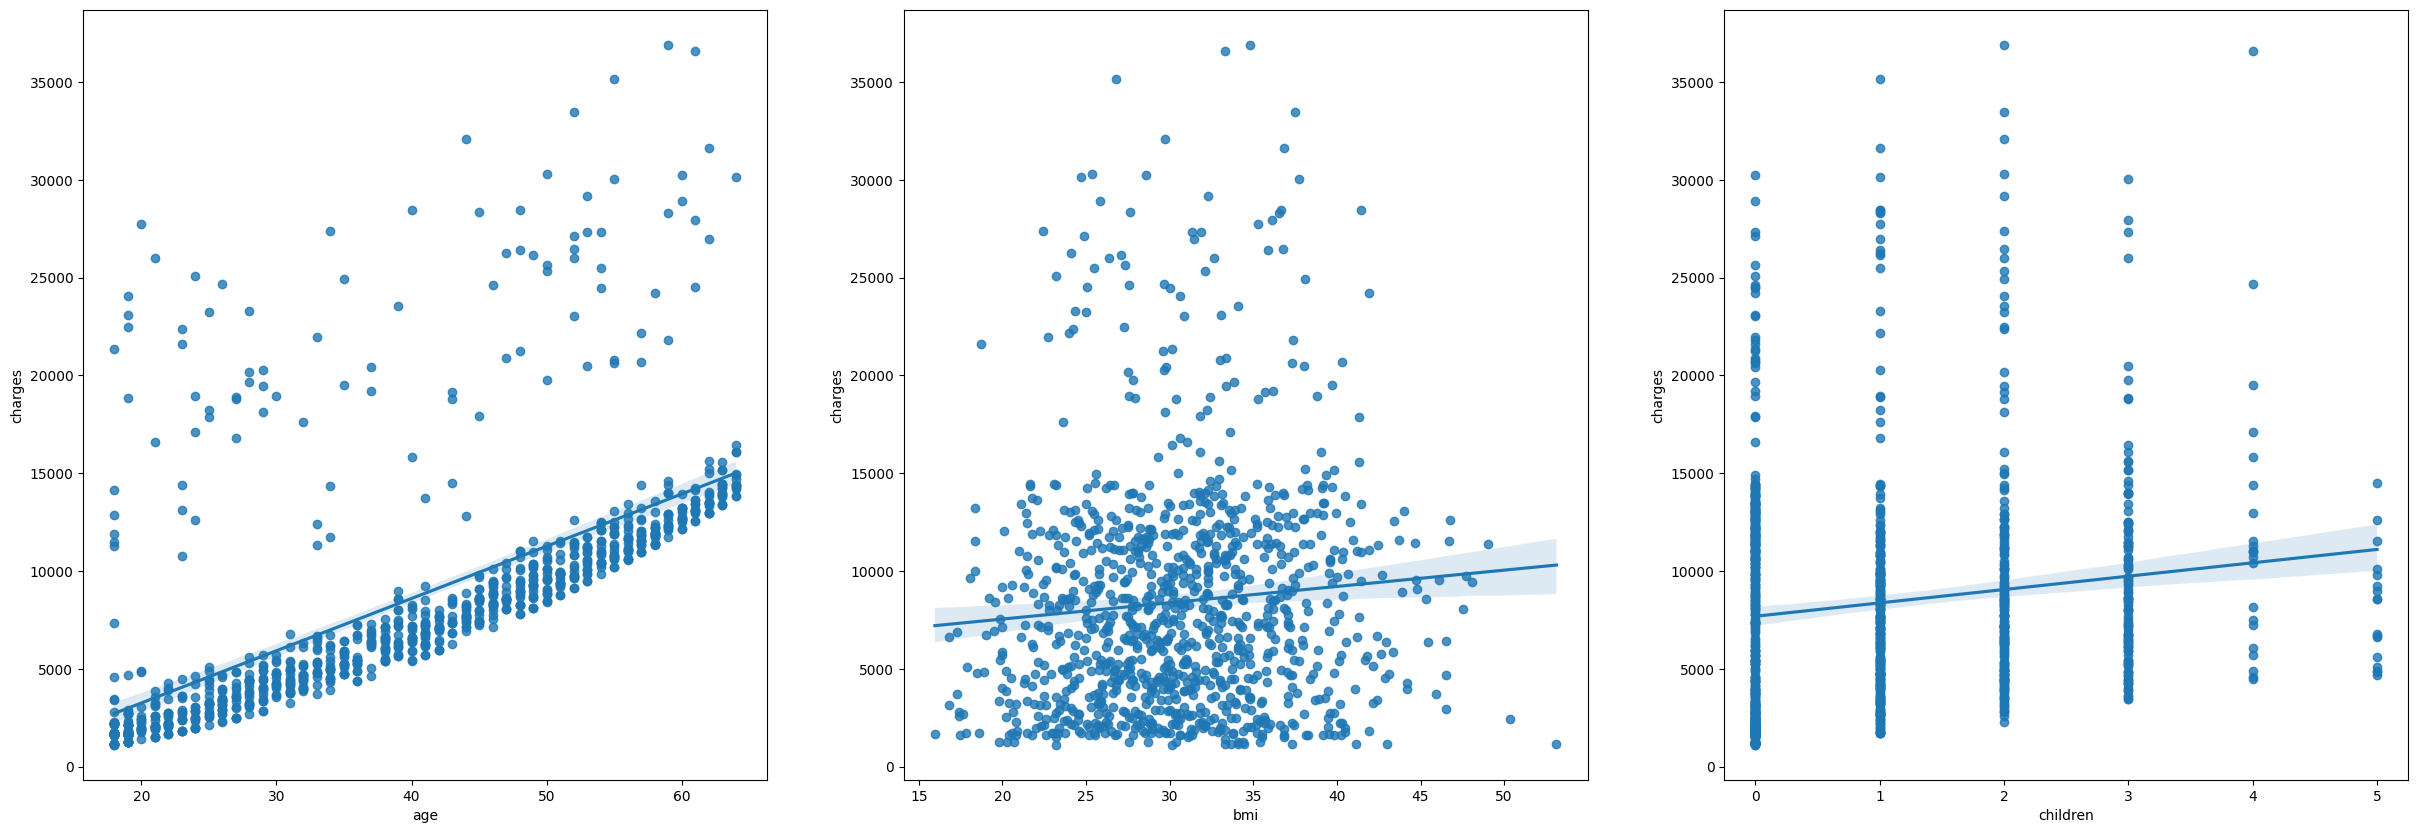

In [79]:
fig, axes = plt.subplots(ncols=3, figsize = (30,10))
axes = axes.flat
columnas = df_non_smoker_numericas.drop(['charges'], axis = 1)  
for i, columns in enumerate(df_non_smoker_numericas.columns):
    sns.regplot(data = df_non_smoker_numericas, x = columns, y = 'charges', ax = axes[i])
fig.tight_layout()

# normalización

In [57]:
df_numericas

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [58]:
df_numericas.head(1)

,age,bmi,children,charges
0,19,27.9,0,16884.924


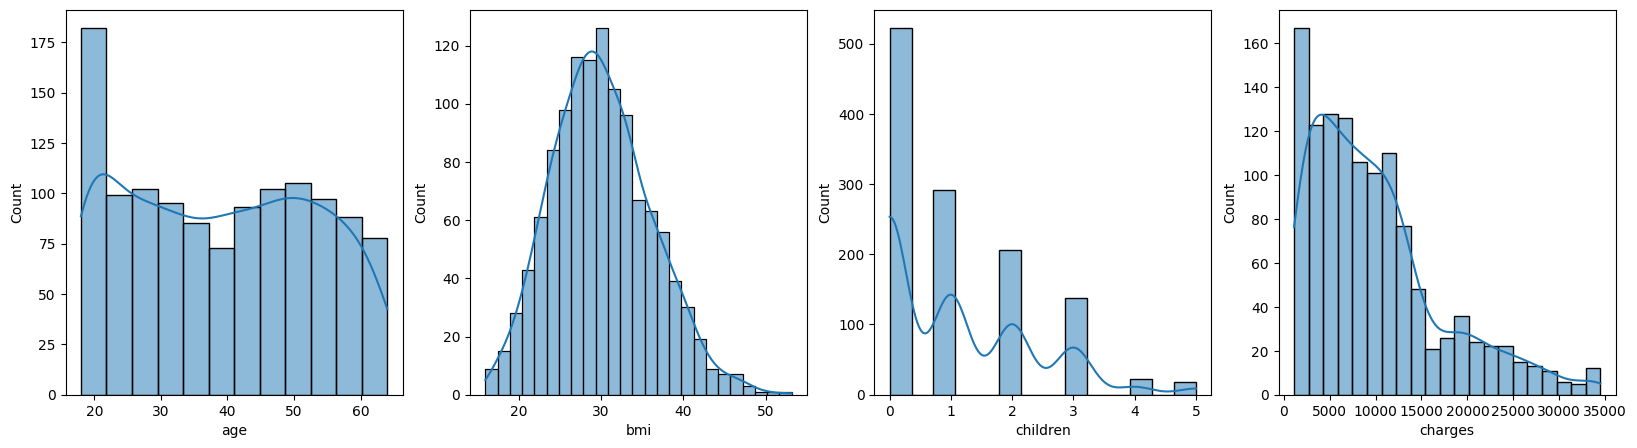

In [59]:
fig, ax = plt.subplots(1,4, figsize = (20,5))

ax = ax.flat
for i, columna in enumerate(df_charges_numericas.columns):
    sns.histplot(data = df_charges_numericas, x = columna, kde = True, ax = ax[i])
    
#fig.delaxes(ax[-1])
plt.show()


In [60]:
stats.shapiro(df_charges["charges"])

ShapiroResult(statistic=0.8944072723388672, pvalue=6.690038329164804e-28)

## logarítmica

In [61]:
df_non_smoker['charges_LOG'] = df_non_smoker['charges'].apply(lambda x: np.log(x) if x != 0 else 0)
df_non_smoker.head()

,age,sex,bmi,children,smoker,region,charges,charges_LOG
1,18,male,33.770,1,no,southeast,1725.55230,7.453302
2,28,male,33.000,3,no,southeast,4449.46200,8.400538
3,33,male,22.705,0,no,northwest,21984.47061,9.998092
4,32,male,28.880,0,no,northwest,3866.85520,8.260197
5,31,female,25.740,0,no,southeast,3756.62160,8.231275


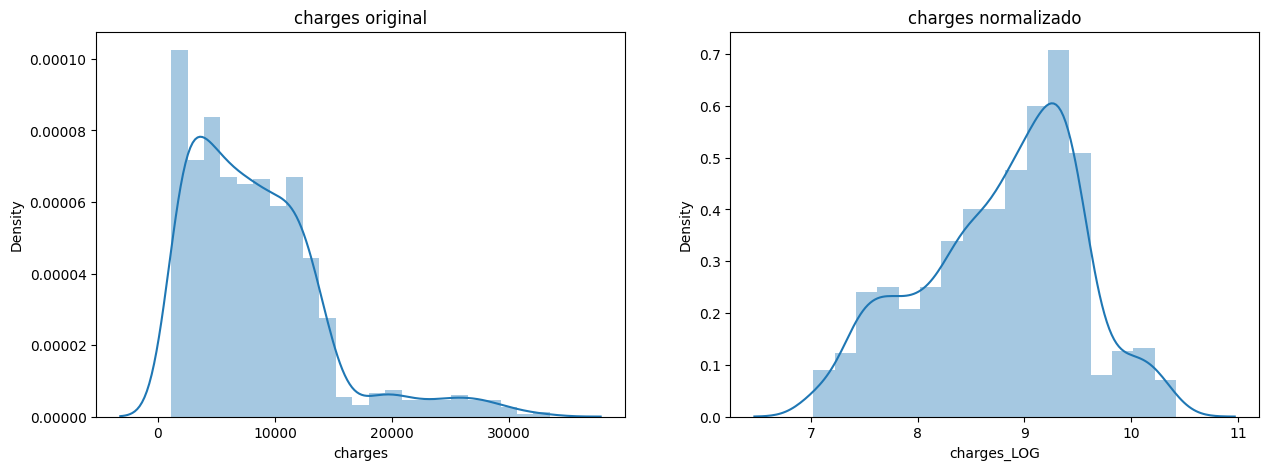

In [62]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df_non_smoker['charges'] ,ax = axes[0])
sns.distplot(df_non_smoker['charges_LOG'], ax = axes[1]);

In [63]:
print(stats.shapiro(df_non_smoker["charges"]), 'log:', stats.shapiro(df_non_smoker["charges_LOG"]))

ShapiroResult(statistic=0.8831536769866943, pvalue=1.5782570263735688e-27) log: ShapiroResult(statistic=0.9744136929512024, pvalue=9.772033442850825e-13)


no se ha acabado de normalizar, pero si que ha corregido un poco la forma desviada a la izquierda y el pvalor crece (aunque sea inferior a 0.05). Vamos a probar otro método.

## raíz cuadrada

In [64]:
df_non_smoker['charges_SQRT'] = df_non_smoker['charges'].apply(lambda x: math.sqrt(x) if x != 0 else 0)
df_non_smoker.head()

,age,sex,bmi,children,smoker,region,charges,charges_LOG,charges_SQRT
1,18,male,33.770,1,no,southeast,1725.55230,7.453302,41.539768
2,28,male,33.000,3,no,southeast,4449.46200,8.400538,66.704288
3,33,male,22.705,0,no,northwest,21984.47061,9.998092,148.271611
4,32,male,28.880,0,no,northwest,3866.85520,8.260197,62.184043
5,31,female,25.740,0,no,southeast,3756.62160,8.231275,61.291285


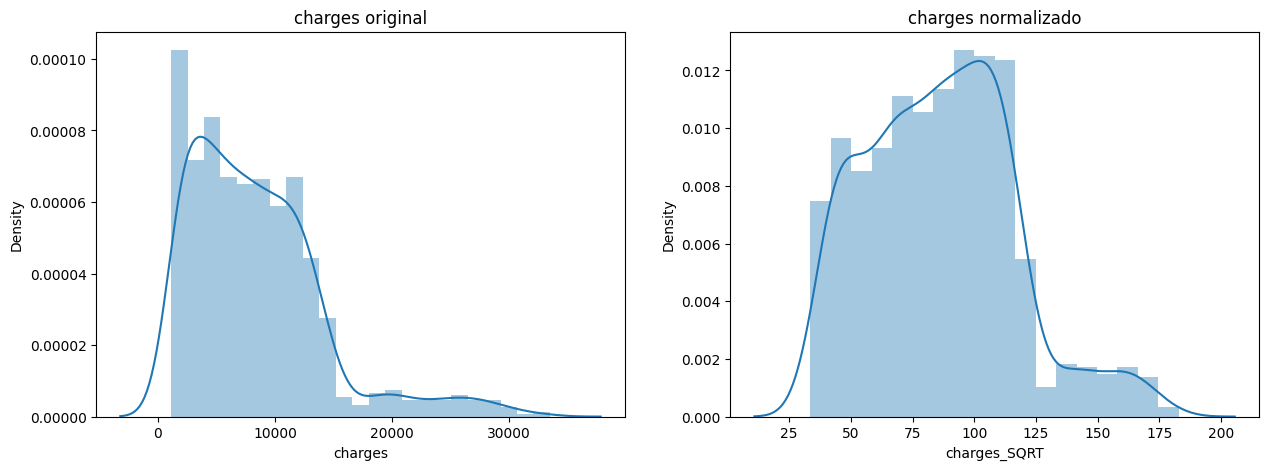

In [65]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df_non_smoker['charges'] ,ax = axes[0])
sns.distplot(df_non_smoker['charges_SQRT'], ax = axes[1]);

In [66]:
print(stats.shapiro(df_non_smoker["charges"]), 
      'log:', stats.shapiro(df_non_smoker["charges_LOG"]), 
      'SQRT:', stats.shapiro(df_non_smoker["charges_SQRT"]))

ShapiroResult(statistic=0.8831536769866943, pvalue=1.5782570263735688e-27) log: ShapiroResult(statistic=0.9744136929512024, pvalue=9.772033442850825e-13) SQRT: ShapiroResult(statistic=0.9700002074241638, pvalue=5.318937293646159e-14)


comparando la transformación logarítmica frente a la raíz cuadrada, la logarítmica obtiene un mejor valor de P-valor (aunque sigue sin ser suficiente). Probaremos ahora con la transformación boxcox.

## boxcox

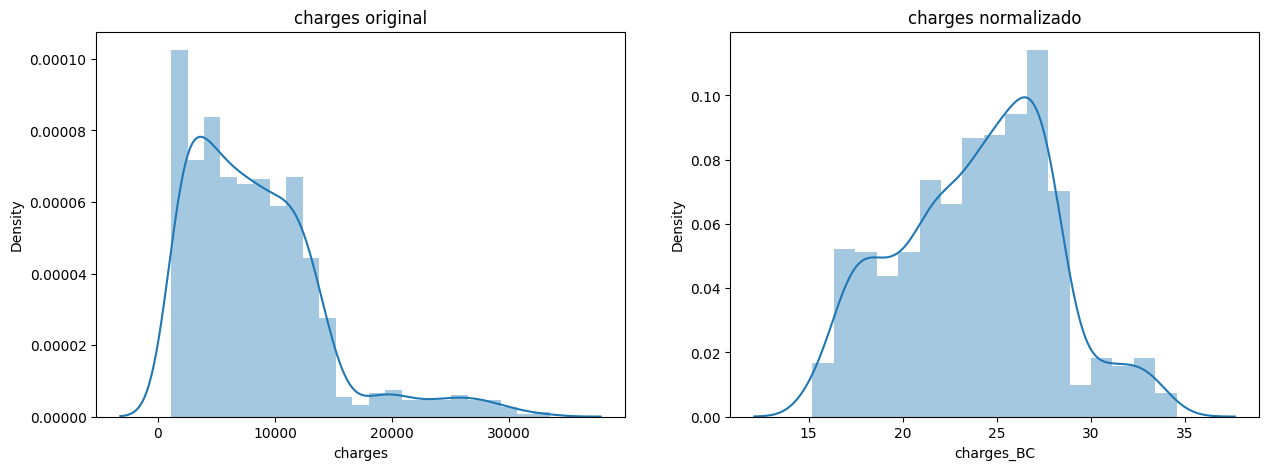

In [67]:
df_non_smoker['charges_BC'], lambda_ajustada = stats.boxcox(df_non_smoker['charges'])
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df_non_smoker['charges'] ,ax = axes[0])
sns.distplot(df_non_smoker['charges_BC'], ax = axes[1]);

In [68]:
print('bc:', stats.shapiro(df_non_smoker["charges_BC"]),'bc:', stats.shapiro(df_non_smoker["charges_LOG"]))

bc: ShapiroResult(statistic=0.9830983877182007, pvalue=9.369343079157488e-10) bc: ShapiroResult(statistic=0.9744136929512024, pvalue=9.772033442850825e-13)


## MinMaxScaler

In [69]:
# construir el modelo de escalador
minmax = MinMaxScaler()

In [70]:
# ajustamos el modelo utilizando nuestro set de datos
minmax.fit(df_non_smoker[["charges"]])

MinMaxScaler()

In [75]:
X_normalizadas = minmax.transform(df_non_smoker[["charges"]])
df_non_smoker["charges_NORM2"] = X_normalizadas
print(X_normalizadas.min(axis=0), X_normalizadas.max(axis=0)) ## checkeo de que las variables lleguen a los valores 0 y 1

[0.] [1.]


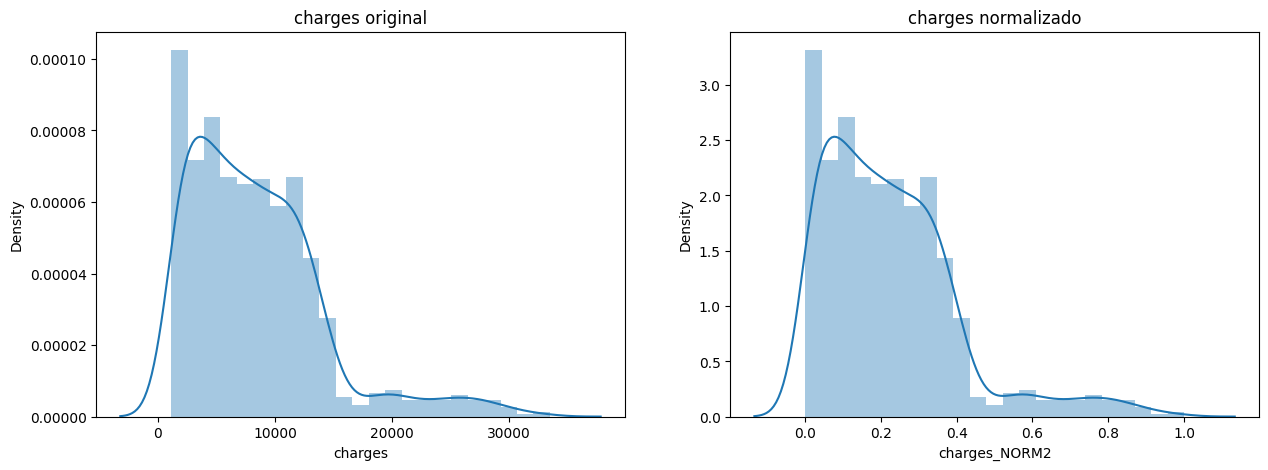

In [76]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('charges original')
axes[1].set_title('charges normalizado')

sns.distplot(df_non_smoker['charges'] ,ax = axes[0])
sns.distplot(df_non_smoker['charges_NORM2'], ax = axes[1]);

In [77]:
print('bc:', stats.shapiro(df_non_smoker["charges_BC"]),'norm2:', stats.shapiro(df_non_smoker["charges_NORM2"]))

bc: ShapiroResult(statistic=0.9830983877182007, pvalue=9.369343079157488e-10) norm2: ShapiroResult(statistic=0.8831537961959839, pvalue=1.5782898634791206e-27)
